In [53]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pickle
import csv
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import gdown
import joblib

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb

import eli5
from eli5.sklearn import PermutationImportance

import os
import glob

# 코드 셀 실행 후 경고를 무시
# import warnings
# warnings.filterwarnings(action='ignore')

### Load Table

In [54]:
# pickle에서 데이터프레임 다시 불러오기
with open('/root/data.pickle', 'rb') as f:
    df = pickle.load(f)

In [55]:
base_path = "/root/"

dt_train = pd.read_csv(base_path + "train.csv")
dt_test = pd.read_csv(base_path + "test.csv")

In [56]:
extra_data_path = '/root/extra_data/'

In [57]:
# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt_train['is_test'] = 0
dt_test['is_test'] = 1
dt = pd.concat([dt_train, dt_test])

In [58]:
df['large_std_동'] = df['동']
df.drop(['동'], axis=1, inplace=True)

In [59]:
dt['동'] = dt['시군구'].apply(lambda x:x.split()[2])

In [60]:
dt = dt.reset_index()

In [61]:
df['동'] = dt['동']

### 년도에따라 동, 구별 statistics 추가

In [62]:
df.drop(['아파트명'], axis=1, inplace=True)

In [63]:
stats = df.groupby(['계약년', '구'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '구'], rsuffix='_target')

In [64]:
df['계약년과구에따른std'] = df['std']
df['계약년과구에따른mean'] = df['mean']
df['계약년과구에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)
df.head(1)

,번지,본번,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,계약년,계약월,평균공시가격,계약일,date,large_std_동,동,계약년과구에따른std,계약년과구에따른mean,계약년과구에따른max
0,658-1,658.0,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,2017,12,120960.0,8,2017-12-08,개포동,개포동,60408.755329,127433.7879,1053000.0


In [65]:
stats = df.groupby(['계약년', '동'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '동'], rsuffix='_target')

In [66]:
df['계약년과동에따른std'] = df['std']
df['계약년과동에따른mean'] = df['mean']
df['계약년과동에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)
df.head(1)

,번지,본번,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,...,계약일,date,large_std_동,동,계약년과구에따른std,계약년과구에따른mean,계약년과구에따른max,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max
0,658-1,658.0,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,...,8,2017-12-08,개포동,개포동,60408.755329,127433.7879,1053000.0,32126.755612,108070.249556,260000.0


In [67]:
# '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max'의 null 값을
# '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'의 값으로 채우기
df['계약년과동에따른std'] = df['계약년과동에따른std'].fillna(df['계약년과구에따른std'])
df['계약년과동에따른mean'] = df['계약년과동에따른mean'].fillna(df['계약년과구에따른mean'])
df['계약년과동에따른max'] = df['계약년과동에따른max'].fillna(df['계약년과구에따른max'])

In [68]:
df.drop(['동', 'large_std_동', 'date', '본번', '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'], axis=1, inplace=True)

In [69]:
df.columns

Index(['번지', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target', 'is_test', '구',
       '계약년', '계약월', '평균공시가격', '계약일', '계약년과동에따른std', '계약년과동에따른mean',
       '계약년과동에따른max'],
      dtype='object')

In [70]:
df['건축년도'].dtype

dtype('int64')

In [71]:
df['계약년월'].dtype

dtype('int64')

In [72]:
df['yrs_diff'] = df['계약년월'].map(lambda x : x // 100) - df['건축년도']

In [73]:
df.columns

Index(['번지', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target', 'is_test', '구',
       '계약년', '계약월', '평균공시가격', '계약일', '계약년과동에따른std', '계약년과동에따른mean',
       '계약년과동에따른max', 'yrs_diff'],
      dtype='object')

In [74]:
# Use glob to find all files that match the pattern
file_paths = glob.glob(extra_data_path + "/KOSPI_*.csv")

# Initialize an empty list to store the dataframes
dfs = []

# Iterate over the file paths and read each CSV file into a dataframe
for file_path in file_paths:
    kospi_df_yr = pd.read_csv(file_path, encoding="euc-kr")
    dfs.append(kospi_df_yr)

kospi_df = pd.concat(dfs, ignore_index=True)
kospi_df = kospi_df.drop(columns=['시가', '고가', '저가'])

In [75]:
kospi_df.rename(columns={"일자":"date", "종가":"Close"}, inplace=True)
kospi_df["date"] = kospi_df['date'].str.replace('/', '-')
kospi_df["date"] = pd.to_datetime(kospi_df["date"])
kospi_df.sort_values(by='date', ascending=True, inplace=True)

In [76]:
kospi_df["Close_delay120d"] = kospi_df["Close"].shift(120)

In [77]:
df.columns

Index(['번지', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target', 'is_test', '구',
       '계약년', '계약월', '평균공시가격', '계약일', '계약년과동에따른std', '계약년과동에따른mean',
       '계약년과동에따른max', 'yrs_diff'],
      dtype='object')

In [78]:
df['date'] = pd.to_datetime(df['계약년'].astype(str) + '-' + df['계약월'].astype(str) + '-' + df['계약일'].astype(str))

In [79]:
df = pd.merge(left=df, right=kospi_df, on='date', how='left')

In [80]:
df.drop(columns=['date', 'Close', '대비', '등락률', '거래량', '거래대금', '상장시가총액'], inplace=True)

In [81]:
df["Close_delay120d"] = df["Close_delay120d"].interpolate(method='linear', axis=0)

In [82]:
df.columns

Index(['번지', '전용면적(㎡)', '계약년월', '층', '건축년도', '도로명', 'target', 'is_test', '구',
       '계약년', '계약월', '평균공시가격', '계약일', '계약년과동에따른std', '계약년과동에따른mean',
       '계약년과동에따른max', 'yrs_diff', 'Close_delay120d'],
      dtype='object')

In [84]:
df.drop(columns=['계약년', '계약월', '계약일'], inplace=True)

### Feature Engineering

### Train

In [85]:
df_train = df.loc[df['is_test']==0, :]
df_test = df.loc[df['is_test']==1, :]

df_train.drop(['is_test'], axis=1, inplace=True)
df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(1118822, 14) (9272, 14)


In [86]:
# 변수 삭제 및 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '계약년월', '층', '건축년도', 'target', '평균공시가격', '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max', 'yrs_diff', 'Close_delay120d']
범주형 변수: ['번지', '도로명', '구']


In [87]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

100%|██████████| 3/3 [00:01<00:00,  2.83it/s]


In [88]:
y_train = df_train['target']
X_train = df_train.drop(['target'], axis=1)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023)

In [98]:
gbm = lgb.LGBMRegressor(n_estimators=2000, max_depth=32, num_leaves=60,
                            feature_fraction=0.8,
                            bagging_fraction=0.9, verbosity=-1)

In [99]:
gbm.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7897.87	training's l2: 6.23763e+07	valid_1's rmse: 8267.76	valid_1's l2: 6.83559e+07
[200]	training's rmse: 6878.63	training's l2: 4.73155e+07	valid_1's rmse: 7390.62	valid_1's l2: 5.46212e+07
[300]	training's rmse: 6351.24	training's l2: 4.03382e+07	valid_1's rmse: 6987.47	valid_1's l2: 4.88247e+07
[400]	training's rmse: 6018.51	training's l2: 3.62225e+07	valid_1's rmse: 6732.5	valid_1's l2: 4.53266e+07
[500]	training's rmse: 5757.99	training's l2: 3.31544e+07	valid_1's rmse: 6562.81	valid_1's l2: 4.30704e+07
[600]	training's rmse: 5550.41	training's l2: 3.08071e+07	valid_1's rmse: 6422.43	valid_1's l2: 4.12476e+07
[700]	training's rmse: 5370.99	training's l2: 2.88475e+07	valid_1's rmse: 6316.47	valid_1's l2: 3.98978e+07
[800]	training's rmse: 5223.03	training's l2: 2.72801e+07	valid_1's rmse: 6240.64	valid_1's l2: 3.89456e+07
[900]	training's rmse: 5095.69	training's l2: 2.59661e+07	valid_1's rmse: 61

LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.8, max_depth=32,
              n_estimators=2000, num_leaves=60, verbosity=-1)

In [91]:
import optuna

def objective(trial):
    # Define the hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 1000, 5000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    num_leaves = trial.suggest_int('num_leaves', 100, 1000)
    min_child_samples = trial.suggest_int('min_child_samples', 50, 500)
    feature_fraction = trial.suggest_float('feature_fraction', 0.5, 1.0)
    bagging_fraction = trial.suggest_float('bagging_fraction', 0.5, 1.0)
    lambda_l1 = trial.suggest_float('lambda_l1', 1e-8, 1.0, log=True)  # Increase L1 regularization
    lambda_l2 = trial.suggest_float('lambda_l2', 1e-8, 1.0, log=True)  # Increase L2 regularization

    # Create the LGBMRegressor model with the suggested hyperparameters
    gbm = lgb.LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, num_leaves=num_leaves,
                            min_child_samples=min_child_samples, feature_fraction=feature_fraction,
                            bagging_fraction=bagging_fraction, lambda_l1=lambda_l1, lambda_l2=lambda_l2, verbosity=-1)

    # Train the model
    gbm.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )
    
    # Compute the validation RMSE
    val_rmse = gbm.best_score_['valid_1']['rmse']
    return val_rmse

def optimize_hyperparameters(n_trials=100, early_stopping=50, log_evaluation=100):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    # Get the best hyperparameters
    best_params = study.best_trial.params

    # Create the final model with the best hyperparameters
    best_model = lgb.LGBMRegressor(**best_params)

    # Train the final model with early stopping and evaluation logging
    best_model.fit(X_train, y_train,
                   eval_set=[(X_train, y_train), (X_val, y_val)],
                   eval_metric='rmse',
                   callbacks=[lgb.early_stopping(stopping_rounds=early_stopping),
                              lgb.log_evaluation(period=log_evaluation, show_stdv=True)])

    return best_model

In [92]:
best_model = optimize_hyperparameters(n_trials=100)

[I 2024-03-29 06:08:47,232] A new study created in memory with name: no-name-6c971f5c-41ad-4746-b0fe-d6104a31f3e3


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6826.27	training's l2: 4.6598e+07	valid_1's rmse: 7273.64	valid_1's l2: 5.29058e+07
[200]	training's rmse: 5978	training's l2: 3.57365e+07	valid_1's rmse: 6596.51	valid_1's l2: 4.3514e+07
[300]	training's rmse: 5552.44	training's l2: 3.08296e+07	valid_1's rmse: 6312.03	valid_1's l2: 3.98418e+07
[400]	training's rmse: 5254.72	training's l2: 2.76121e+07	valid_1's rmse: 6140.8	valid_1's l2: 3.77094e+07
[500]	training's rmse: 5027.56	training's l2: 2.52763e+07	valid_1's rmse: 6020.36	valid_1's l2: 3.62447e+07
[600]	training's rmse: 4848.59	training's l2: 2.35088e+07	valid_1's rmse: 5936.97	valid_1's l2: 3.52476e+07
[700]	training's rmse: 4702.92	training's l2: 2.21175e+07	valid_1's rmse: 5876.67	valid_1's l2: 3.45352e+07
[800]	training's rmse: 4580.74	training's l2: 2.09832e+07	valid_1's rmse: 5828.32	valid_1's l2: 3.39693e+07
[900]	training's rmse: 4466.16	training's l2: 1.99465e+07	valid_1's rmse: 5790.81

[I 2024-03-29 06:09:20,838] Trial 0 finished with value: 5629.778980137126 and parameters: {'n_estimators': 3124, 'max_depth': 19, 'num_leaves': 184, 'min_child_samples': 117, 'feature_fraction': 0.8655354186907093, 'bagging_fraction': 0.5420442497371379, 'lambda_l1': 0.0059463209434837795, 'lambda_l2': 0.005179325034105218}. Best is trial 0 with value: 5629.778980137126.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7296.4	training's l2: 5.32374e+07	valid_1's rmse: 7729.15	valid_1's l2: 5.97397e+07
[200]	training's rmse: 6556.9	training's l2: 4.2993e+07	valid_1's rmse: 7067.49	valid_1's l2: 4.99494e+07
[300]	training's rmse: 6191.77	training's l2: 3.8338e+07	valid_1's rmse: 6763.78	valid_1's l2: 4.57487e+07
[400]	training's rmse: 5932.35	training's l2: 3.51928e+07	valid_1's rmse: 6561.79	valid_1's l2: 4.30571e+07
[500]	training's rmse: 5745.46	training's l2: 3.30103e+07	valid_1's rmse: 6428.14	valid_1's l2: 4.1321e+07
[600]	training's rmse: 5593.2	training's l2: 3.12839e+07	valid_1's rmse: 6327.15	valid_1's l2: 4.00328e+07
[700]	training's rmse: 5462.96	training's l2: 2.98439e+07	valid_1's rmse: 6247.56	valid_1's l2: 3.90319e+07
[800]	training's rmse: 5355.45	training's l2: 2.86808e+07	valid_1's rmse: 6181.39	valid_1's l2: 3.82095e+07
[900]	training's rmse: 5252.83	training's l2: 2.75922e+07	valid_1's rmse: 6122.18

[I 2024-03-29 06:10:22,312] Trial 1 finished with value: 5701.6251738597575 and parameters: {'n_estimators': 3386, 'max_depth': 24, 'num_leaves': 909, 'min_child_samples': 496, 'feature_fraction': 0.5867817671727742, 'bagging_fraction': 0.8011984545213326, 'lambda_l1': 9.573183205162214e-07, 'lambda_l2': 0.20593403052437848}. Best is trial 0 with value: 5629.778980137126.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7007.52	training's l2: 4.91053e+07	valid_1's rmse: 7464.78	valid_1's l2: 5.57229e+07
[200]	training's rmse: 6239.13	training's l2: 3.89267e+07	valid_1's rmse: 6795.93	valid_1's l2: 4.61847e+07
[300]	training's rmse: 5885.58	training's l2: 3.464e+07	valid_1's rmse: 6526.78	valid_1's l2: 4.25989e+07
[400]	training's rmse: 5659.11	training's l2: 3.20256e+07	valid_1's rmse: 6360.23	valid_1's l2: 4.04525e+07
[500]	training's rmse: 5483.59	training's l2: 3.00697e+07	valid_1's rmse: 6243.99	valid_1's l2: 3.89875e+07
[600]	training's rmse: 5336.12	training's l2: 2.84742e+07	valid_1's rmse: 6157.29	valid_1's l2: 3.79122e+07
[700]	training's rmse: 5216.26	training's l2: 2.72094e+07	valid_1's rmse: 6093.36	valid_1's l2: 3.7129e+07
[800]	training's rmse: 5106.33	training's l2: 2.60746e+07	valid_1's rmse: 6037.63	valid_1's l2: 3.6453e+07
[900]	training's rmse: 5012.14	training's l2: 2.51216e+07	valid_1's rmse: 5990.

[I 2024-03-29 06:11:15,491] Trial 2 finished with value: 5654.601333752736 and parameters: {'n_estimators': 4222, 'max_depth': 18, 'num_leaves': 564, 'min_child_samples': 316, 'feature_fraction': 0.520288903156026, 'bagging_fraction': 0.5428916242225204, 'lambda_l1': 0.00031117228603807194, 'lambda_l2': 7.115447777717055e-05}. Best is trial 0 with value: 5629.778980137126.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 5996.21	training's l2: 3.59546e+07	valid_1's rmse: 6715.69	valid_1's l2: 4.51004e+07
[200]	training's rmse: 5213.72	training's l2: 2.71828e+07	valid_1's rmse: 6224.19	valid_1's l2: 3.87405e+07
[300]	training's rmse: 4820.45	training's l2: 2.32367e+07	valid_1's rmse: 6032.31	valid_1's l2: 3.63888e+07
[400]	training's rmse: 4544.81	training's l2: 2.06553e+07	valid_1's rmse: 5931.39	valid_1's l2: 3.51813e+07
[500]	training's rmse: 4333.29	training's l2: 1.87774e+07	valid_1's rmse: 5867.65	valid_1's l2: 3.44294e+07
[600]	training's rmse: 4160.72	training's l2: 1.73116e+07	valid_1's rmse: 5823.48	valid_1's l2: 3.39129e+07
[700]	training's rmse: 4009.69	training's l2: 1.60776e+07	valid_1's rmse: 5790.02	valid_1's l2: 3.35243e+07
[800]	training's rmse: 3879.42	training's l2: 1.50499e+07	valid_1's rmse: 5767.33	valid_1's l2: 3.32621e+07
[900]	training's rmse: 3751.67	training's l2: 1.4075e+07	valid_1's rmse: 57

[I 2024-03-29 06:12:10,567] Trial 3 finished with value: 5690.788777667878 and parameters: {'n_estimators': 4661, 'max_depth': 46, 'num_leaves': 880, 'min_child_samples': 176, 'feature_fraction': 0.9877954131203295, 'bagging_fraction': 0.865993827907031, 'lambda_l1': 4.5534517137325456e-05, 'lambda_l2': 6.941124940829318e-08}. Best is trial 0 with value: 5629.778980137126.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7348.18	training's l2: 5.39957e+07	valid_1's rmse: 7691.81	valid_1's l2: 5.9164e+07
[200]	training's rmse: 6617.12	training's l2: 4.37863e+07	valid_1's rmse: 7046.47	valid_1's l2: 4.96528e+07
[300]	training's rmse: 6192.55	training's l2: 3.83477e+07	valid_1's rmse: 6708.37	valid_1's l2: 4.50022e+07
[400]	training's rmse: 5927.61	training's l2: 3.51365e+07	valid_1's rmse: 6508.71	valid_1's l2: 4.23633e+07
[500]	training's rmse: 5733.88	training's l2: 3.28774e+07	valid_1's rmse: 6378.38	valid_1's l2: 4.06838e+07
[600]	training's rmse: 5568.07	training's l2: 3.10034e+07	valid_1's rmse: 6267.48	valid_1's l2: 3.92813e+07
[700]	training's rmse: 5435.21	training's l2: 2.95415e+07	valid_1's rmse: 6185.02	valid_1's l2: 3.82545e+07
[800]	training's rmse: 5321.59	training's l2: 2.83193e+07	valid_1's rmse: 6117.44	valid_1's l2: 3.74231e+07
[900]	training's rmse: 5232.17	training's l2: 2.73756e+07	valid_1's rmse: 60

[I 2024-03-29 06:13:02,747] Trial 4 finished with value: 5684.11932974708 and parameters: {'n_estimators': 3524, 'max_depth': 15, 'num_leaves': 250, 'min_child_samples': 285, 'feature_fraction': 0.9410255628257411, 'bagging_fraction': 0.8060245302340379, 'lambda_l1': 0.00038308315816321933, 'lambda_l2': 3.06304772636211e-05}. Best is trial 0 with value: 5629.778980137126.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6501.6	training's l2: 4.22707e+07	valid_1's rmse: 7054.84	valid_1's l2: 4.97708e+07
[200]	training's rmse: 5629.34	training's l2: 3.16894e+07	valid_1's rmse: 6396.56	valid_1's l2: 4.0916e+07
[300]	training's rmse: 5219.33	training's l2: 2.72414e+07	valid_1's rmse: 6144.79	valid_1's l2: 3.77584e+07
[400]	training's rmse: 4936.39	training's l2: 2.43679e+07	valid_1's rmse: 5997.67	valid_1's l2: 3.59721e+07
[500]	training's rmse: 4716.75	training's l2: 2.22477e+07	valid_1's rmse: 5905.2	valid_1's l2: 3.48713e+07
[600]	training's rmse: 4538.06	training's l2: 2.0594e+07	valid_1's rmse: 5836.18	valid_1's l2: 3.40609e+07
[700]	training's rmse: 4385.08	training's l2: 1.92289e+07	valid_1's rmse: 5788.13	valid_1's l2: 3.35024e+07
[800]	training's rmse: 4250.28	training's l2: 1.80649e+07	valid_1's rmse: 5752.39	valid_1's l2: 3.30899e+07
[900]	training's rmse: 4131.21	training's l2: 1.70669e+07	valid_1's rmse: 5723.

[I 2024-03-29 06:13:57,167] Trial 5 finished with value: 5629.626873270228 and parameters: {'n_estimators': 2150, 'max_depth': 46, 'num_leaves': 609, 'min_child_samples': 245, 'feature_fraction': 0.645521191570331, 'bagging_fraction': 0.870661533215308, 'lambda_l1': 7.589072716211618e-07, 'lambda_l2': 0.028676491178549125}. Best is trial 5 with value: 5629.626873270228.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6540.13	training's l2: 4.27733e+07	valid_1's rmse: 7075.18	valid_1's l2: 5.00582e+07
[200]	training's rmse: 5674.38	training's l2: 3.21986e+07	valid_1's rmse: 6421.63	valid_1's l2: 4.12374e+07
[300]	training's rmse: 5255.76	training's l2: 2.76231e+07	valid_1's rmse: 6157.72	valid_1's l2: 3.79176e+07
[400]	training's rmse: 4968.43	training's l2: 2.46853e+07	valid_1's rmse: 6003.71	valid_1's l2: 3.60446e+07
[500]	training's rmse: 4761.74	training's l2: 2.26742e+07	valid_1's rmse: 5911.48	valid_1's l2: 3.49456e+07
[600]	training's rmse: 4586.5	training's l2: 2.10359e+07	valid_1's rmse: 5840.64	valid_1's l2: 3.41131e+07
[700]	training's rmse: 4439.02	training's l2: 1.97049e+07	valid_1's rmse: 5789.88	valid_1's l2: 3.35227e+07
[800]	training's rmse: 4308.62	training's l2: 1.85642e+07	valid_1's rmse: 5752.84	valid_1's l2: 3.30951e+07
[900]	training's rmse: 4194.03	training's l2: 1.75899e+07	valid_1's rmse: 57

[I 2024-03-29 06:14:31,552] Trial 6 finished with value: 5632.534096875083 and parameters: {'n_estimators': 2815, 'max_depth': 50, 'num_leaves': 292, 'min_child_samples': 142, 'feature_fraction': 0.6594250689184595, 'bagging_fraction': 0.5801632956301286, 'lambda_l1': 0.428133202319477, 'lambda_l2': 0.10287546125626398}. Best is trial 5 with value: 5629.626873270228.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6540.65	training's l2: 4.27801e+07	valid_1's rmse: 7060.62	valid_1's l2: 4.98524e+07
[200]	training's rmse: 5647.21	training's l2: 3.1891e+07	valid_1's rmse: 6395.36	valid_1's l2: 4.09006e+07
[300]	training's rmse: 5223.32	training's l2: 2.7283e+07	valid_1's rmse: 6155.4	valid_1's l2: 3.7889e+07
[400]	training's rmse: 4941.22	training's l2: 2.44157e+07	valid_1's rmse: 6014.78	valid_1's l2: 3.61776e+07
[500]	training's rmse: 4713.36	training's l2: 2.22157e+07	valid_1's rmse: 5926.85	valid_1's l2: 3.51276e+07
[600]	training's rmse: 4538.8	training's l2: 2.06007e+07	valid_1's rmse: 5862.44	valid_1's l2: 3.43682e+07
[700]	training's rmse: 4391.87	training's l2: 1.92886e+07	valid_1's rmse: 5812.27	valid_1's l2: 3.37824e+07
[800]	training's rmse: 4262.48	training's l2: 1.81687e+07	valid_1's rmse: 5773.96	valid_1's l2: 3.33386e+07
[900]	training's rmse: 4147.42	training's l2: 1.72011e+07	valid_1's rmse: 5753.5

[I 2024-03-29 06:14:48,995] Trial 7 finished with value: 5700.27231122223 and parameters: {'n_estimators': 1243, 'max_depth': 31, 'num_leaves': 230, 'min_child_samples': 90, 'feature_fraction': 0.8052733125167706, 'bagging_fraction': 0.6300694945278205, 'lambda_l1': 0.142856261128387, 'lambda_l2': 0.00274129959328606}. Best is trial 5 with value: 5629.626873270228.


Did not meet early stopping. Best iteration is:
[1243]	training's rmse: 3843.88	training's l2: 1.47754e+07	valid_1's rmse: 5700.27	valid_1's l2: 3.24931e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7584.2	training's l2: 5.75201e+07	valid_1's rmse: 7982.98	valid_1's l2: 6.3728e+07
[200]	training's rmse: 6901.92	training's l2: 4.76365e+07	valid_1's rmse: 7340.12	valid_1's l2: 5.38774e+07
[300]	training's rmse: 6518.51	training's l2: 4.2491e+07	valid_1's rmse: 7003.61	valid_1's l2: 4.90506e+07
[400]	training's rmse: 6252.31	training's l2: 3.90914e+07	valid_1's rmse: 6786.57	valid_1's l2: 4.60575e+07
[500]	training's rmse: 6038.06	training's l2: 3.64581e+07	valid_1's rmse: 6619.36	valid_1's l2: 4.3816e+07
[600]	training's rmse: 5866.35	training's l2: 3.4414e+07	valid_1's rmse: 6500.63	valid_1's l2: 4.22582e+07
[700]	training's rmse: 5725.69	training's l2: 3.27835e+07	valid_1's rmse: 6406.25	valid_1's l2: 4.104e+07
[800]	training's rmse: 5610.04	tr

[I 2024-03-29 06:15:53,284] Trial 8 finished with value: 5743.09474902949 and parameters: {'n_estimators': 3788, 'max_depth': 23, 'num_leaves': 528, 'min_child_samples': 500, 'feature_fraction': 0.9919808045054521, 'bagging_fraction': 0.5494585101881949, 'lambda_l1': 3.962784901465511e-06, 'lambda_l2': 0.0689521659684103}. Best is trial 5 with value: 5629.626873270228.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6528.25	training's l2: 4.26181e+07	valid_1's rmse: 7101.94	valid_1's l2: 5.04376e+07
[200]	training's rmse: 5826.26	training's l2: 3.39453e+07	valid_1's rmse: 6548.6	valid_1's l2: 4.28842e+07
[300]	training's rmse: 5518.2	training's l2: 3.04506e+07	valid_1's rmse: 6335.84	valid_1's l2: 4.01428e+07
[400]	training's rmse: 5277.25	training's l2: 2.78494e+07	valid_1's rmse: 6181.64	valid_1's l2: 3.82126e+07
[500]	training's rmse: 5098.11	training's l2: 2.59907e+07	valid_1's rmse: 6080.11	valid_1's l2: 3.69678e+07
[600]	training's rmse: 4947.45	training's l2: 2.44773e+07	valid_1's rmse: 6004.58	valid_1's l2: 3.6055e+07
[700]	training's rmse: 4814.55	training's l2: 2.31799e+07	valid_1's rmse: 5947.64	valid_1's l2: 3.53744e+07
[800]	training's rmse: 4708.28	training's l2: 2.21679e+07	valid_1's rmse: 5904.02	valid_1's l2: 3.48574e+07
[900]	training's rmse: 4612.68	training's l2: 2.12768e+07	valid_1's rmse: 5862

[I 2024-03-29 06:16:14,013] Trial 9 finished with value: 5813.214327037084 and parameters: {'n_estimators': 1081, 'max_depth': 19, 'num_leaves': 677, 'min_child_samples': 227, 'feature_fraction': 0.6201967732262759, 'bagging_fraction': 0.5206917718897421, 'lambda_l1': 0.0632281076114782, 'lambda_l2': 8.563070234564573e-08}. Best is trial 5 with value: 5629.626873270228.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6835.18	training's l2: 4.67196e+07	valid_1's rmse: 7303.4	valid_1's l2: 5.33396e+07
[200]	training's rmse: 6009.95	training's l2: 3.61195e+07	valid_1's rmse: 6643.14	valid_1's l2: 4.41313e+07
[300]	training's rmse: 5622	training's l2: 3.16068e+07	valid_1's rmse: 6376.97	valid_1's l2: 4.06657e+07
[400]	training's rmse: 5357.03	training's l2: 2.86978e+07	valid_1's rmse: 6207.01	valid_1's l2: 3.8527e+07
[500]	training's rmse: 5161.1	training's l2: 2.66369e+07	valid_1's rmse: 6098.54	valid_1's l2: 3.71921e+07
[600]	training's rmse: 5001.23	training's l2: 2.50123e+07	valid_1's rmse: 6017.5	valid_1's l2: 3.62102e+07
[700]	training's rmse: 4857.69	training's l2: 2.35971e+07	valid_1's rmse: 5957.1	valid_1's l2: 3.5487e+07
[800]	training's rmse: 4739.94	training's l2: 2.2467e+07	valid_1's rmse: 5910.67	valid_1's l2: 3.49361e+07
[900]	training's rmse: 4635.09	training's l2: 2.14841e+07	valid_1's rmse: 5868.45	val

[I 2024-03-29 06:17:11,656] Trial 10 finished with value: 5679.762848165304 and parameters: {'n_estimators': 2072, 'max_depth': 38, 'num_leaves': 702, 'min_child_samples': 380, 'feature_fraction': 0.7207729147018361, 'bagging_fraction': 0.9704224344978193, 'lambda_l1': 1.743450196581667e-08, 'lambda_l2': 3.7167097671382636e-06}. Best is trial 5 with value: 5629.626873270228.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6195.81	training's l2: 3.83881e+07	valid_1's rmse: 6897.15	valid_1's l2: 4.75707e+07
[200]	training's rmse: 5440.45	training's l2: 2.95985e+07	valid_1's rmse: 6339.58	valid_1's l2: 4.01903e+07
[300]	training's rmse: 5111.96	training's l2: 2.61321e+07	valid_1's rmse: 6142.63	valid_1's l2: 3.77319e+07
[400]	training's rmse: 4837.35	training's l2: 2.33999e+07	valid_1's rmse: 5996.09	valid_1's l2: 3.59531e+07
[500]	training's rmse: 4678.84	training's l2: 2.18915e+07	valid_1's rmse: 5927.13	valid_1's l2: 3.51308e+07
[600]	training's rmse: 4511.44	training's l2: 2.03531e+07	valid_1's rmse: 5861.08	valid_1's l2: 3.43523e+07
[700]	training's rmse: 4389.64	training's l2: 1.9269e+07	valid_1's rmse: 5824.88	valid_1's l2: 3.39292e+07
[800]	training's rmse: 4297.67	training's l2: 1.847e+07	valid_1's rmse: 5798.8	valid_1's l2: 3.36261e+07
[900]	training's rmse: 4195.06	training's l2: 1.75985e+07	valid_1's rmse: 5767.

[I 2024-03-29 06:17:39,632] Trial 11 finished with value: 5658.498339858975 and parameters: {'n_estimators': 2528, 'max_depth': 11, 'num_leaves': 428, 'min_child_samples': 56, 'feature_fraction': 0.8320541943563781, 'bagging_fraction': 0.6997468911785876, 'lambda_l1': 0.004655759219550354, 'lambda_l2': 0.003750578237835473}. Best is trial 5 with value: 5629.626873270228.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7372.91	training's l2: 5.43599e+07	valid_1's rmse: 7696.36	valid_1's l2: 5.9234e+07
[200]	training's rmse: 6490.35	training's l2: 4.21247e+07	valid_1's rmse: 6937.79	valid_1's l2: 4.81329e+07
[300]	training's rmse: 6052.35	training's l2: 3.66309e+07	valid_1's rmse: 6602.75	valid_1's l2: 4.35963e+07
[400]	training's rmse: 5755.27	training's l2: 3.31232e+07	valid_1's rmse: 6391.78	valid_1's l2: 4.08548e+07
[500]	training's rmse: 5543.14	training's l2: 3.07264e+07	valid_1's rmse: 6254.48	valid_1's l2: 3.91185e+07
[600]	training's rmse: 5357.98	training's l2: 2.8708e+07	valid_1's rmse: 6138.64	valid_1's l2: 3.76829e+07
[700]	training's rmse: 5215.62	training's l2: 2.72027e+07	valid_1's rmse: 6058.94	valid_1's l2: 3.67108e+07
[800]	training's rmse: 5097.05	training's l2: 2.59799e+07	valid_1's rmse: 5993.22	valid_1's l2: 3.59187e+07
[900]	training's rmse: 4984.79	training's l2: 2.48481e+07	valid_1's rmse: 593

[I 2024-03-29 06:18:03,648] Trial 12 finished with value: 5676.423210646403 and parameters: {'n_estimators': 1989, 'max_depth': 35, 'num_leaves': 138, 'min_child_samples': 210, 'feature_fraction': 0.8718613367167133, 'bagging_fraction': 0.9368216045641868, 'lambda_l1': 1.1454943684907219e-07, 'lambda_l2': 0.0025975432330734415}. Best is trial 5 with value: 5629.626873270228.


Did not meet early stopping. Best iteration is:
[1985]	training's rmse: 4216.61	training's l2: 1.77798e+07	valid_1's rmse: 5676.42	valid_1's l2: 3.22218e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6249.5	training's l2: 3.90562e+07	valid_1's rmse: 6863.45	valid_1's l2: 4.7107e+07
[200]	training's rmse: 5377.23	training's l2: 2.89146e+07	valid_1's rmse: 6255.97	valid_1's l2: 3.91372e+07
[300]	training's rmse: 4946.48	training's l2: 2.44677e+07	valid_1's rmse: 6026	valid_1's l2: 3.63126e+07
[400]	training's rmse: 4653.76	training's l2: 2.16575e+07	valid_1's rmse: 5889.96	valid_1's l2: 3.46916e+07
[500]	training's rmse: 4432.45	training's l2: 1.96466e+07	valid_1's rmse: 5810.54	valid_1's l2: 3.37624e+07
[600]	training's rmse: 4250.61	training's l2: 1.80677e+07	valid_1's rmse: 5752.62	valid_1's l2: 3.30926e+07
[700]	training's rmse: 4094.14	training's l2: 1.67619e+07	valid_1's rmse: 5719.01	valid_1's l2: 3.27071e+07
[800]	training's rmse: 3963.49	

[I 2024-03-29 06:18:30,315] Trial 13 finished with value: 5642.940589746948 and parameters: {'n_estimators': 2264, 'max_depth': 45, 'num_leaves': 418, 'min_child_samples': 128, 'feature_fraction': 0.7269590330260303, 'bagging_fraction': 0.6970126663179246, 'lambda_l1': 1.1847687850715417e-05, 'lambda_l2': 0.006522373292301491}. Best is trial 5 with value: 5629.626873270228.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6923.06	training's l2: 4.79287e+07	valid_1's rmse: 7395.56	valid_1's l2: 5.46944e+07
[200]	training's rmse: 6187.84	training's l2: 3.82893e+07	valid_1's rmse: 6783.05	valid_1's l2: 4.60098e+07
[300]	training's rmse: 5828	training's l2: 3.39656e+07	valid_1's rmse: 6528.83	valid_1's l2: 4.26256e+07
[400]	training's rmse: 5583.61	training's l2: 3.11767e+07	valid_1's rmse: 6359.78	valid_1's l2: 4.04468e+07
[500]	training's rmse: 5388.63	training's l2: 2.90374e+07	valid_1's rmse: 6240.61	valid_1's l2: 3.89452e+07
[600]	training's rmse: 5230.62	training's l2: 2.73594e+07	valid_1's rmse: 6143.85	valid_1's l2: 3.77469e+07
[700]	training's rmse: 5100.88	training's l2: 2.60189e+07	valid_1's rmse: 6079.01	valid_1's l2: 3.69544e+07
[800]	training's rmse: 4984.68	training's l2: 2.4847e+07	valid_1's rmse: 6019.49	valid_1's l2: 3.62343e+07
[900]	training's rmse: 4882.63	training's l2: 2.38401e+07	valid_1's rmse: 5972.

[I 2024-03-29 06:19:06,133] Trial 14 finished with value: 5778.013559399948 and parameters: {'n_estimators': 1648, 'max_depth': 28, 'num_leaves': 750, 'min_child_samples': 385, 'feature_fraction': 0.7707849856615208, 'bagging_fraction': 0.8960847827639182, 'lambda_l1': 0.0028806364390451577, 'lambda_l2': 0.0003495790972336314}. Best is trial 5 with value: 5629.626873270228.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7712.58	training's l2: 5.94838e+07	valid_1's rmse: 7990.08	valid_1's l2: 6.38413e+07
[200]	training's rmse: 6807.18	training's l2: 4.63377e+07	valid_1's rmse: 7167.43	valid_1's l2: 5.1372e+07
[300]	training's rmse: 6365.68	training's l2: 4.05219e+07	valid_1's rmse: 6798.25	valid_1's l2: 4.62162e+07
[400]	training's rmse: 6058.85	training's l2: 3.67097e+07	valid_1's rmse: 6566.04	valid_1's l2: 4.31129e+07
[500]	training's rmse: 5836.47	training's l2: 3.40644e+07	valid_1's rmse: 6399.46	valid_1's l2: 4.0953e+07
[600]	training's rmse: 5662	training's l2: 3.20582e+07	valid_1's rmse: 6278.8	valid_1's l2: 3.94233e+07
[700]	training's rmse: 5506.76	training's l2: 3.03244e+07	valid_1's rmse: 6183.22	valid_1's l2: 3.82323e+07
[800]	training's rmse: 5379.23	training's l2: 2.89362e+07	valid_1's rmse: 6104.93	valid_1's l2: 3.72702e+07
[900]	training's rmse: 5265.92	training's l2: 2.77299e+07	valid_1's rmse: 6036.44

[I 2024-03-29 06:19:43,522] Trial 15 finished with value: 5629.337226609367 and parameters: {'n_estimators': 3025, 'max_depth': 39, 'num_leaves': 104, 'min_child_samples': 242, 'feature_fraction': 0.8940568644223889, 'bagging_fraction': 0.766637490589644, 'lambda_l1': 4.812970553764221e-07, 'lambda_l2': 0.5995169631758428}. Best is trial 15 with value: 5629.337226609367.


Did not meet early stopping. Best iteration is:
[3022]	training's rmse: 4100.84	training's l2: 1.68169e+07	valid_1's rmse: 5629.34	valid_1's l2: 3.16894e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6875.17	training's l2: 4.72679e+07	valid_1's rmse: 7315.07	valid_1's l2: 5.35103e+07
[200]	training's rmse: 6023.54	training's l2: 3.6283e+07	valid_1's rmse: 6614.45	valid_1's l2: 4.3751e+07
[300]	training's rmse: 5621.94	training's l2: 3.16062e+07	valid_1's rmse: 6339.6	valid_1's l2: 4.01905e+07
[400]	training's rmse: 5342.19	training's l2: 2.8539e+07	valid_1's rmse: 6163.82	valid_1's l2: 3.79927e+07
[500]	training's rmse: 5134.6	training's l2: 2.63641e+07	valid_1's rmse: 6052.42	valid_1's l2: 3.66318e+07
[600]	training's rmse: 4960.93	training's l2: 2.46108e+07	valid_1's rmse: 5971.09	valid_1's l2: 3.5654e+07
[700]	training's rmse: 4815.65	training's l2: 2.31904e+07	valid_1's rmse: 5909.09	valid_1's l2: 3.49174e+07
[800]	training's rmse: 4685.14	t

[I 2024-03-29 06:20:43,036] Trial 16 finished with value: 5625.390321317796 and parameters: {'n_estimators': 2757, 'max_depth': 40, 'num_leaves': 374, 'min_child_samples': 313, 'feature_fraction': 0.6809671700626385, 'bagging_fraction': 0.7824023638487977, 'lambda_l1': 4.861599869055992e-07, 'lambda_l2': 0.4635138656538631}. Best is trial 16 with value: 5625.390321317796.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7005.57	training's l2: 4.9078e+07	valid_1's rmse: 7434.16	valid_1's l2: 5.52667e+07
[200]	training's rmse: 6150.2	training's l2: 3.78249e+07	valid_1's rmse: 6716.12	valid_1's l2: 4.51062e+07
[300]	training's rmse: 5733.37	training's l2: 3.28715e+07	valid_1's rmse: 6430.27	valid_1's l2: 4.13484e+07
[400]	training's rmse: 5446.38	training's l2: 2.9663e+07	valid_1's rmse: 6244.29	valid_1's l2: 3.89912e+07
[500]	training's rmse: 5226.1	training's l2: 2.73122e+07	valid_1's rmse: 6122.16	valid_1's l2: 3.74808e+07
[600]	training's rmse: 5052.59	training's l2: 2.55286e+07	valid_1's rmse: 6028.74	valid_1's l2: 3.63457e+07
[700]	training's rmse: 4902.36	training's l2: 2.40331e+07	valid_1's rmse: 5958.74	valid_1's l2: 3.55066e+07
[800]	training's rmse: 4775.96	training's l2: 2.28098e+07	valid_1's rmse: 5906.75	valid_1's l2: 3.48897e+07
[900]	training's rmse: 4664.91	training's l2: 2.17614e+07	valid_1's rmse: 5869.

[I 2024-03-29 06:21:44,536] Trial 17 finished with value: 5658.499541137444 and parameters: {'n_estimators': 2824, 'max_depth': 41, 'num_leaves': 363, 'min_child_samples': 344, 'feature_fraction': 0.8974913237168345, 'bagging_fraction': 0.7435130030175015, 'lambda_l1': 4.794378003241303e-08, 'lambda_l2': 0.9546583291535308}. Best is trial 16 with value: 5625.390321317796.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 8009.22	training's l2: 6.41477e+07	valid_1's rmse: 8288.42	valid_1's l2: 6.86979e+07
[200]	training's rmse: 7092.3	training's l2: 5.03007e+07	valid_1's rmse: 7435.45	valid_1's l2: 5.52859e+07
[300]	training's rmse: 6646.19	training's l2: 4.41718e+07	valid_1's rmse: 7063.89	valid_1's l2: 4.98985e+07
[400]	training's rmse: 6335.1	training's l2: 4.01335e+07	valid_1's rmse: 6808.95	valid_1's l2: 4.63617e+07
[500]	training's rmse: 6110.9	training's l2: 3.73431e+07	valid_1's rmse: 6634.95	valid_1's l2: 4.40226e+07
[600]	training's rmse: 5927.34	training's l2: 3.51333e+07	valid_1's rmse: 6496.99	valid_1's l2: 4.22108e+07
[700]	training's rmse: 5774.51	training's l2: 3.33449e+07	valid_1's rmse: 6390.63	valid_1's l2: 4.08401e+07
[800]	training's rmse: 5649.63	training's l2: 3.19183e+07	valid_1's rmse: 6305.65	valid_1's l2: 3.97613e+07
[900]	training's rmse: 5539.14	training's l2: 3.06821e+07	valid_1's rmse: 6231

[I 2024-03-29 06:22:29,288] Trial 18 finished with value: 5653.297378851461 and parameters: {'n_estimators': 3946, 'max_depth': 34, 'num_leaves': 104, 'min_child_samples': 416, 'feature_fraction': 0.7054083273628099, 'bagging_fraction': 0.8032879418433008, 'lambda_l1': 3.8133279851997306e-07, 'lambda_l2': 0.5621845002395632}. Best is trial 16 with value: 5625.390321317796.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6814.29	training's l2: 4.64346e+07	valid_1's rmse: 7271.64	valid_1's l2: 5.28767e+07
[200]	training's rmse: 5986.67	training's l2: 3.58402e+07	valid_1's rmse: 6592.69	valid_1's l2: 4.34636e+07
[300]	training's rmse: 5581.24	training's l2: 3.11502e+07	valid_1's rmse: 6313.91	valid_1's l2: 3.98655e+07
[400]	training's rmse: 5304.91	training's l2: 2.8142e+07	valid_1's rmse: 6146.54	valid_1's l2: 3.778e+07
[500]	training's rmse: 5094.36	training's l2: 2.59525e+07	valid_1's rmse: 6033.54	valid_1's l2: 3.64036e+07
[600]	training's rmse: 4915.95	training's l2: 2.41666e+07	valid_1's rmse: 5949.28	valid_1's l2: 3.53939e+07
[700]	training's rmse: 4768.7	training's l2: 2.27405e+07	valid_1's rmse: 5880.98	valid_1's l2: 3.45859e+07
[800]	training's rmse: 4639.92	training's l2: 2.15289e+07	valid_1's rmse: 5830.48	valid_1's l2: 3.39945e+07
[900]	training's rmse: 4524.13	training's l2: 2.04677e+07	valid_1's rmse: 5795.

[I 2024-03-29 06:23:28,274] Trial 19 finished with value: 5613.66865681313 and parameters: {'n_estimators': 3083, 'max_depth': 40, 'num_leaves': 370, 'min_child_samples': 290, 'feature_fraction': 0.7727770797556927, 'bagging_fraction': 0.6730069024846537, 'lambda_l1': 4.9271531331088405e-06, 'lambda_l2': 1.683634595323683e-06}. Best is trial 19 with value: 5613.66865681313.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6689.89	training's l2: 4.47547e+07	valid_1's rmse: 7143.9	valid_1's l2: 5.10353e+07
[200]	training's rmse: 5863.84	training's l2: 3.43846e+07	valid_1's rmse: 6504.04	valid_1's l2: 4.23025e+07
[300]	training's rmse: 5458.62	training's l2: 2.97965e+07	valid_1's rmse: 6237.51	valid_1's l2: 3.89066e+07
[400]	training's rmse: 5181.98	training's l2: 2.68529e+07	valid_1's rmse: 6079.27	valid_1's l2: 3.69575e+07
[500]	training's rmse: 4970.13	training's l2: 2.47022e+07	valid_1's rmse: 5971.89	valid_1's l2: 3.56634e+07
[600]	training's rmse: 4797.67	training's l2: 2.30176e+07	valid_1's rmse: 5900.81	valid_1's l2: 3.48196e+07
[700]	training's rmse: 4649.05	training's l2: 2.16137e+07	valid_1's rmse: 5844.47	valid_1's l2: 3.41578e+07
[800]	training's rmse: 4516.84	training's l2: 2.04019e+07	valid_1's rmse: 5801.91	valid_1's l2: 3.36622e+07
[900]	training's rmse: 4402.87	training's l2: 1.93853e+07	valid_1's rmse: 57

[I 2024-03-29 06:24:29,438] Trial 20 finished with value: 5628.832322908293 and parameters: {'n_estimators': 4995, 'max_depth': 42, 'num_leaves': 480, 'min_child_samples': 292, 'feature_fraction': 0.7756867958694905, 'bagging_fraction': 0.6670993554720153, 'lambda_l1': 9.603544272107487e-06, 'lambda_l2': 7.749730133322948e-07}. Best is trial 19 with value: 5613.66865681313.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6707.9	training's l2: 4.4996e+07	valid_1's rmse: 7187.17	valid_1's l2: 5.16554e+07
[200]	training's rmse: 5886.06	training's l2: 3.46457e+07	valid_1's rmse: 6537.82	valid_1's l2: 4.27431e+07
[300]	training's rmse: 5484.84	training's l2: 3.00835e+07	valid_1's rmse: 6279.13	valid_1's l2: 3.94275e+07
[400]	training's rmse: 5205.4	training's l2: 2.70962e+07	valid_1's rmse: 6120.87	valid_1's l2: 3.7465e+07
[500]	training's rmse: 4993.93	training's l2: 2.49394e+07	valid_1's rmse: 6017.62	valid_1's l2: 3.62117e+07
[600]	training's rmse: 4815.16	training's l2: 2.31858e+07	valid_1's rmse: 5940.65	valid_1's l2: 3.52913e+07
[700]	training's rmse: 4666.41	training's l2: 2.17754e+07	valid_1's rmse: 5886.77	valid_1's l2: 3.46541e+07
[800]	training's rmse: 4538.28	training's l2: 2.05959e+07	valid_1's rmse: 5844.72	valid_1's l2: 3.41607e+07
[900]	training's rmse: 4424.45	training's l2: 1.95758e+07	valid_1's rmse: 5809.

[I 2024-03-29 06:25:25,559] Trial 21 finished with value: 5664.234700737649 and parameters: {'n_estimators': 4983, 'max_depth': 42, 'num_leaves': 486, 'min_child_samples': 298, 'feature_fraction': 0.78191333620725, 'bagging_fraction': 0.6434711243913176, 'lambda_l1': 6.022058463153494e-06, 'lambda_l2': 1.2078196589849569e-06}. Best is trial 19 with value: 5613.66865681313.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6988.01	training's l2: 4.88323e+07	valid_1's rmse: 7390.71	valid_1's l2: 5.46226e+07
[200]	training's rmse: 6127.19	training's l2: 3.75424e+07	valid_1's rmse: 6659.45	valid_1's l2: 4.43483e+07
[300]	training's rmse: 5721.29	training's l2: 3.27332e+07	valid_1's rmse: 6366.51	valid_1's l2: 4.05325e+07
[400]	training's rmse: 5437.81	training's l2: 2.95698e+07	valid_1's rmse: 6184.69	valid_1's l2: 3.82504e+07
[500]	training's rmse: 5227.69	training's l2: 2.73288e+07	valid_1's rmse: 6060.67	valid_1's l2: 3.67317e+07
[600]	training's rmse: 5052.1	training's l2: 2.55237e+07	valid_1's rmse: 5974.99	valid_1's l2: 3.57005e+07
[700]	training's rmse: 4905.07	training's l2: 2.40597e+07	valid_1's rmse: 5903.04	valid_1's l2: 3.48459e+07
[800]	training's rmse: 4777.91	training's l2: 2.28284e+07	valid_1's rmse: 5851.3	valid_1's l2: 3.42378e+07
[900]	training's rmse: 4666.24	training's l2: 2.17738e+07	valid_1's rmse: 580

[I 2024-03-29 06:26:33,108] Trial 22 finished with value: 5592.024583075908 and parameters: {'n_estimators': 4355, 'max_depth': 50, 'num_leaves': 345, 'min_child_samples': 337, 'feature_fraction': 0.683883363878019, 'bagging_fraction': 0.6538753605155287, 'lambda_l1': 4.39107731954615e-05, 'lambda_l2': 1.0139360375177064e-08}. Best is trial 22 with value: 5592.024583075908.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6994.32	training's l2: 4.89205e+07	valid_1's rmse: 7400.63	valid_1's l2: 5.47694e+07
[200]	training's rmse: 6134.86	training's l2: 3.76365e+07	valid_1's rmse: 6685.61	valid_1's l2: 4.46974e+07
[300]	training's rmse: 5720.37	training's l2: 3.27226e+07	valid_1's rmse: 6388.45	valid_1's l2: 4.08123e+07
[400]	training's rmse: 5432.27	training's l2: 2.95095e+07	valid_1's rmse: 6209.58	valid_1's l2: 3.85589e+07
[500]	training's rmse: 5221.54	training's l2: 2.72645e+07	valid_1's rmse: 6086.35	valid_1's l2: 3.70437e+07
[600]	training's rmse: 5045.2	training's l2: 2.5454e+07	valid_1's rmse: 5996.66	valid_1's l2: 3.59599e+07
[700]	training's rmse: 4894.42	training's l2: 2.39553e+07	valid_1's rmse: 5930.48	valid_1's l2: 3.51707e+07
[800]	training's rmse: 4764.56	training's l2: 2.2701e+07	valid_1's rmse: 5880.37	valid_1's l2: 3.45788e+07
[900]	training's rmse: 4650.28	training's l2: 2.16251e+07	valid_1's rmse: 5837

[I 2024-03-29 06:27:43,828] Trial 23 finished with value: 5622.464982811801 and parameters: {'n_estimators': 4394, 'max_depth': 50, 'num_leaves': 366, 'min_child_samples': 350, 'feature_fraction': 0.680698644452772, 'bagging_fraction': 0.5984112707608223, 'lambda_l1': 3.933848575407105e-05, 'lambda_l2': 2.1218099986105775e-08}. Best is trial 22 with value: 5592.024583075908.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7443.92	training's l2: 5.54119e+07	valid_1's rmse: 7853.72	valid_1's l2: 6.16809e+07
[200]	training's rmse: 6503.73	training's l2: 4.22985e+07	valid_1's rmse: 7010.79	valid_1's l2: 4.91511e+07
[300]	training's rmse: 6068.82	training's l2: 3.68306e+07	valid_1's rmse: 6666.92	valid_1's l2: 4.44479e+07
[400]	training's rmse: 5775.06	training's l2: 3.33513e+07	valid_1's rmse: 6448.97	valid_1's l2: 4.15892e+07
[500]	training's rmse: 5554.75	training's l2: 3.08552e+07	valid_1's rmse: 6300.21	valid_1's l2: 3.96927e+07
[600]	training's rmse: 5375.95	training's l2: 2.89009e+07	valid_1's rmse: 6191.8	valid_1's l2: 3.83384e+07
[700]	training's rmse: 5230.26	training's l2: 2.73556e+07	valid_1's rmse: 6109.67	valid_1's l2: 3.7328e+07
[800]	training's rmse: 5099.99	training's l2: 2.60099e+07	valid_1's rmse: 6037.27	valid_1's l2: 3.64486e+07
[900]	training's rmse: 4985.6	training's l2: 2.48563e+07	valid_1's rmse: 5981

[I 2024-03-29 06:29:18,834] Trial 24 finished with value: 5626.873821225869 and parameters: {'n_estimators': 4386, 'max_depth': 49, 'num_leaves': 309, 'min_child_samples': 438, 'feature_fraction': 0.553363053603338, 'bagging_fraction': 0.6049188866987439, 'lambda_l1': 5.878758702502527e-05, 'lambda_l2': 1.2090728200581094e-08}. Best is trial 22 with value: 5592.024583075908.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7126.17	training's l2: 5.07823e+07	valid_1's rmse: 7543.77	valid_1's l2: 5.69085e+07
[200]	training's rmse: 6214.44	training's l2: 3.86193e+07	valid_1's rmse: 6756.47	valid_1's l2: 4.56499e+07
[300]	training's rmse: 5796.46	training's l2: 3.35989e+07	valid_1's rmse: 6450.9	valid_1's l2: 4.16141e+07
[400]	training's rmse: 5507.13	training's l2: 3.03285e+07	valid_1's rmse: 6263.2	valid_1's l2: 3.92276e+07
[500]	training's rmse: 5288.4	training's l2: 2.79672e+07	valid_1's rmse: 6130.9	valid_1's l2: 3.75879e+07
[600]	training's rmse: 5116.15	training's l2: 2.61749e+07	valid_1's rmse: 6035.59	valid_1's l2: 3.64283e+07
[700]	training's rmse: 4968.31	training's l2: 2.46841e+07	valid_1's rmse: 5963.96	valid_1's l2: 3.55689e+07
[800]	training's rmse: 4837.45	training's l2: 2.34009e+07	valid_1's rmse: 5906.66	valid_1's l2: 3.48887e+07
[900]	training's rmse: 4723.15	training's l2: 2.23082e+07	valid_1's rmse: 5861.

[I 2024-03-29 06:30:31,040] Trial 25 finished with value: 5607.973790483574 and parameters: {'n_estimators': 4422, 'max_depth': 50, 'num_leaves': 326, 'min_child_samples': 348, 'feature_fraction': 0.6102285480325201, 'bagging_fraction': 0.7132845876882181, 'lambda_l1': 0.00018081544287510724, 'lambda_l2': 1.5515874671270842e-08}. Best is trial 22 with value: 5592.024583075908.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7368.29	training's l2: 5.42917e+07	valid_1's rmse: 7753.98	valid_1's l2: 6.01242e+07
[200]	training's rmse: 6479.37	training's l2: 4.19822e+07	valid_1's rmse: 6968.87	valid_1's l2: 4.85652e+07
[300]	training's rmse: 6055.36	training's l2: 3.66674e+07	valid_1's rmse: 6636.01	valid_1's l2: 4.40367e+07
[400]	training's rmse: 5760.99	training's l2: 3.3189e+07	valid_1's rmse: 6433.59	valid_1's l2: 4.13911e+07
[500]	training's rmse: 5544.25	training's l2: 3.07387e+07	valid_1's rmse: 6288.52	valid_1's l2: 3.95455e+07
[600]	training's rmse: 5367.86	training's l2: 2.88139e+07	valid_1's rmse: 6181.52	valid_1's l2: 3.82111e+07
[700]	training's rmse: 5221.73	training's l2: 2.72665e+07	valid_1's rmse: 6103.42	valid_1's l2: 3.72517e+07
[800]	training's rmse: 5094.47	training's l2: 2.59536e+07	valid_1's rmse: 6040.97	valid_1's l2: 3.64934e+07
[900]	training's rmse: 4980.52	training's l2: 2.48056e+07	valid_1's rmse: 59

[I 2024-03-29 06:32:03,591] Trial 26 finished with value: 5629.7319284419345 and parameters: {'n_estimators': 4043, 'max_depth': 45, 'num_leaves': 294, 'min_child_samples': 443, 'feature_fraction': 0.6020858062336479, 'bagging_fraction': 0.7267616627883624, 'lambda_l1': 0.000613276046362456, 'lambda_l2': 2.2321034818112155e-07}. Best is trial 22 with value: 5592.024583075908.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7518.1	training's l2: 5.65219e+07	valid_1's rmse: 7874.97	valid_1's l2: 6.20151e+07
[200]	training's rmse: 6565.97	training's l2: 4.3112e+07	valid_1's rmse: 7024.35	valid_1's l2: 4.93415e+07
[300]	training's rmse: 6128.19	training's l2: 3.75548e+07	valid_1's rmse: 6672.11	valid_1's l2: 4.4517e+07
[400]	training's rmse: 5829.61	training's l2: 3.39844e+07	valid_1's rmse: 6445.41	valid_1's l2: 4.15433e+07
[500]	training's rmse: 5616.46	training's l2: 3.15446e+07	valid_1's rmse: 6293.1	valid_1's l2: 3.96031e+07
[600]	training's rmse: 5437.46	training's l2: 2.9566e+07	valid_1's rmse: 6177.92	valid_1's l2: 3.81666e+07
[700]	training's rmse: 5288.32	training's l2: 2.79663e+07	valid_1's rmse: 6090	valid_1's l2: 3.70881e+07
[800]	training's rmse: 5157.74	training's l2: 2.66022e+07	valid_1's rmse: 6020.24	valid_1's l2: 3.62433e+07
[900]	training's rmse: 5048.41	training's l2: 2.54865e+07	valid_1's rmse: 5967.03	v

[I 2024-03-29 06:33:11,214] Trial 27 finished with value: 5607.033579148349 and parameters: {'n_estimators': 3638, 'max_depth': 47, 'num_leaves': 201, 'min_child_samples': 351, 'feature_fraction': 0.551446334608118, 'bagging_fraction': 0.6730942670462674, 'lambda_l1': 0.0007819753962843617, 'lambda_l2': 5.644592593589024e-06}. Best is trial 22 with value: 5592.024583075908.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7648.83	training's l2: 5.85046e+07	valid_1's rmse: 7993.8	valid_1's l2: 6.39009e+07
[200]	training's rmse: 6674.97	training's l2: 4.45552e+07	valid_1's rmse: 7105.3	valid_1's l2: 5.04852e+07
[300]	training's rmse: 6239.38	training's l2: 3.89298e+07	valid_1's rmse: 6747.11	valid_1's l2: 4.55235e+07
[400]	training's rmse: 5937.99	training's l2: 3.52597e+07	valid_1's rmse: 6512.06	valid_1's l2: 4.2407e+07
[500]	training's rmse: 5720.37	training's l2: 3.27227e+07	valid_1's rmse: 6358.01	valid_1's l2: 4.04243e+07
[600]	training's rmse: 5540.58	training's l2: 3.0698e+07	valid_1's rmse: 6241.47	valid_1's l2: 3.8956e+07
[700]	training's rmse: 5397.31	training's l2: 2.9131e+07	valid_1's rmse: 6160.1	valid_1's l2: 3.79468e+07
[800]	training's rmse: 5269.86	training's l2: 2.77714e+07	valid_1's rmse: 6090.23	valid_1's l2: 3.70909e+07
[900]	training's rmse: 5163.69	training's l2: 2.66636e+07	valid_1's rmse: 6030.96	

[I 2024-03-29 06:34:11,944] Trial 28 finished with value: 5635.2364598659915 and parameters: {'n_estimators': 3551, 'max_depth': 48, 'num_leaves': 180, 'min_child_samples': 381, 'feature_fraction': 0.5316750342560197, 'bagging_fraction': 0.7259262539585486, 'lambda_l1': 0.0010445709458604244, 'lambda_l2': 9.921445003915719e-06}. Best is trial 22 with value: 5592.024583075908.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7427.38	training's l2: 5.5166e+07	valid_1's rmse: 7791.97	valid_1's l2: 6.07147e+07
[200]	training's rmse: 6476.09	training's l2: 4.19397e+07	valid_1's rmse: 6946.25	valid_1's l2: 4.82503e+07
[300]	training's rmse: 6036.22	training's l2: 3.6436e+07	valid_1's rmse: 6599.75	valid_1's l2: 4.35567e+07
[400]	training's rmse: 5742.64	training's l2: 3.2978e+07	valid_1's rmse: 6372.8	valid_1's l2: 4.06125e+07
[500]	training's rmse: 5531.66	training's l2: 3.05993e+07	valid_1's rmse: 6231.58	valid_1's l2: 3.88326e+07
[600]	training's rmse: 5356.12	training's l2: 2.8688e+07	valid_1's rmse: 6127.58	valid_1's l2: 3.75472e+07
[700]	training's rmse: 5212.37	training's l2: 2.71688e+07	valid_1's rmse: 6043.62	valid_1's l2: 3.65253e+07
[800]	training's rmse: 5084.46	training's l2: 2.58518e+07	valid_1's rmse: 5983.49	valid_1's l2: 3.58021e+07
[900]	training's rmse: 4974.32	training's l2: 2.47438e+07	valid_1's rmse: 5929.3

[I 2024-03-29 06:35:21,495] Trial 29 finished with value: 5601.943185664542 and parameters: {'n_estimators': 3732, 'max_depth': 47, 'num_leaves': 216, 'min_child_samples': 335, 'feature_fraction': 0.5593838271596256, 'bagging_fraction': 0.6241463641206233, 'lambda_l1': 0.018656252989593065, 'lambda_l2': 2.119716241993603e-07}. Best is trial 22 with value: 5592.024583075908.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7657.54	training's l2: 5.8638e+07	valid_1's rmse: 8017.56	valid_1's l2: 6.42812e+07
[200]	training's rmse: 6697.12	training's l2: 4.48514e+07	valid_1's rmse: 7146.9	valid_1's l2: 5.10782e+07
[300]	training's rmse: 6262.49	training's l2: 3.92188e+07	valid_1's rmse: 6795.8	valid_1's l2: 4.6183e+07
[400]	training's rmse: 5959.61	training's l2: 3.55169e+07	valid_1's rmse: 6560.76	valid_1's l2: 4.30436e+07
[500]	training's rmse: 5738.7	training's l2: 3.29327e+07	valid_1's rmse: 6408.96	valid_1's l2: 4.10747e+07
[600]	training's rmse: 5560.07	training's l2: 3.09144e+07	valid_1's rmse: 6290.75	valid_1's l2: 3.95736e+07
[700]	training's rmse: 5416.02	training's l2: 2.93333e+07	valid_1's rmse: 6204.05	valid_1's l2: 3.84903e+07
[800]	training's rmse: 5290.2	training's l2: 2.79862e+07	valid_1's rmse: 6132.78	valid_1's l2: 3.7611e+07
[900]	training's rmse: 5180.96	training's l2: 2.68424e+07	valid_1's rmse: 6074.23	

[I 2024-03-29 06:36:29,619] Trial 30 finished with value: 5652.542008376118 and parameters: {'n_estimators': 3631, 'max_depth': 36, 'num_leaves': 188, 'min_child_samples': 404, 'feature_fraction': 0.5678767170684151, 'bagging_fraction': 0.6433930758997294, 'lambda_l1': 0.021777525986215122, 'lambda_l2': 3.483758108804593e-07}. Best is trial 22 with value: 5592.024583075908.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7343.07	training's l2: 5.39207e+07	valid_1's rmse: 7710.86	valid_1's l2: 5.94573e+07
[200]	training's rmse: 6444.78	training's l2: 4.15352e+07	valid_1's rmse: 6909	valid_1's l2: 4.77343e+07
[300]	training's rmse: 6023.66	training's l2: 3.62845e+07	valid_1's rmse: 6578.05	valid_1's l2: 4.32707e+07
[400]	training's rmse: 5737.82	training's l2: 3.29226e+07	valid_1's rmse: 6368.94	valid_1's l2: 4.05633e+07
[500]	training's rmse: 5522.16	training's l2: 3.04942e+07	valid_1's rmse: 6226.9	valid_1's l2: 3.87743e+07
[600]	training's rmse: 5350.03	training's l2: 2.86228e+07	valid_1's rmse: 6123.22	valid_1's l2: 3.74938e+07
[700]	training's rmse: 5207.69	training's l2: 2.71201e+07	valid_1's rmse: 6045.37	valid_1's l2: 3.65465e+07
[800]	training's rmse: 5079.63	training's l2: 2.58026e+07	valid_1's rmse: 5983.01	valid_1's l2: 3.57964e+07
[900]	training's rmse: 4973.67	training's l2: 2.47374e+07	valid_1's rmse: 5928.

[I 2024-03-29 06:37:29,218] Trial 31 finished with value: 5590.332785511218 and parameters: {'n_estimators': 4629, 'max_depth': 44, 'num_leaves': 210, 'min_child_samples': 343, 'feature_fraction': 0.6234897235215779, 'bagging_fraction': 0.6863410501976306, 'lambda_l1': 0.020384640067150104, 'lambda_l2': 3.6765598201065787e-08}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7446.17	training's l2: 5.54455e+07	valid_1's rmse: 7814.83	valid_1's l2: 6.10716e+07
[200]	training's rmse: 6497.91	training's l2: 4.22228e+07	valid_1's rmse: 6963.34	valid_1's l2: 4.84882e+07
[300]	training's rmse: 6051.75	training's l2: 3.66237e+07	valid_1's rmse: 6613.39	valid_1's l2: 4.37369e+07
[400]	training's rmse: 5761.28	training's l2: 3.31923e+07	valid_1's rmse: 6400.53	valid_1's l2: 4.09667e+07
[500]	training's rmse: 5546.36	training's l2: 3.07621e+07	valid_1's rmse: 6251.51	valid_1's l2: 3.90814e+07
[600]	training's rmse: 5369.61	training's l2: 2.88327e+07	valid_1's rmse: 6142.47	valid_1's l2: 3.77299e+07
[700]	training's rmse: 5224.5	training's l2: 2.72954e+07	valid_1's rmse: 6060.07	valid_1's l2: 3.67245e+07
[800]	training's rmse: 5099.56	training's l2: 2.60055e+07	valid_1's rmse: 5997.11	valid_1's l2: 3.59653e+07
[900]	training's rmse: 4986.77	training's l2: 2.48679e+07	valid_1's rmse: 59

[I 2024-03-29 06:38:39,505] Trial 32 finished with value: 5599.2508999113315 and parameters: {'n_estimators': 4607, 'max_depth': 44, 'num_leaves': 218, 'min_child_samples': 339, 'feature_fraction': 0.5703525422240837, 'bagging_fraction': 0.673590602548221, 'lambda_l1': 0.019182282599879724, 'lambda_l2': 7.156873339747022e-08}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7153.63	training's l2: 5.11745e+07	valid_1's rmse: 7564.52	valid_1's l2: 5.72219e+07
[200]	training's rmse: 6220.54	training's l2: 3.86951e+07	valid_1's rmse: 6770.88	valid_1's l2: 4.58448e+07
[300]	training's rmse: 5780.8	training's l2: 3.34177e+07	valid_1's rmse: 6454.92	valid_1's l2: 4.1666e+07
[400]	training's rmse: 5481.79	training's l2: 3.00501e+07	valid_1's rmse: 6248.86	valid_1's l2: 3.90482e+07
[500]	training's rmse: 5265.66	training's l2: 2.77272e+07	valid_1's rmse: 6113.6	valid_1's l2: 3.73761e+07
[600]	training's rmse: 5093.84	training's l2: 2.59472e+07	valid_1's rmse: 6028	valid_1's l2: 3.63368e+07
[700]	training's rmse: 4948.51	training's l2: 2.44878e+07	valid_1's rmse: 5955.51	valid_1's l2: 3.5468e+07
[800]	training's rmse: 4821.13	training's l2: 2.32433e+07	valid_1's rmse: 5901.39	valid_1's l2: 3.48264e+07
[900]	training's rmse: 4713.79	training's l2: 2.22198e+07	valid_1's rmse: 5852.61	

[I 2024-03-29 06:39:46,498] Trial 33 finished with value: 5595.424632284291 and parameters: {'n_estimators': 4659, 'max_depth': 44, 'num_leaves': 253, 'min_child_samples': 257, 'feature_fraction': 0.5131187504605894, 'bagging_fraction': 0.5797425390554277, 'lambda_l1': 0.014729412348239983, 'lambda_l2': 1.4390741556949415e-07}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7153.83	training's l2: 5.11773e+07	valid_1's rmse: 7555.93	valid_1's l2: 5.7092e+07
[200]	training's rmse: 6202.23	training's l2: 3.84676e+07	valid_1's rmse: 6737.72	valid_1's l2: 4.53968e+07
[300]	training's rmse: 5774.57	training's l2: 3.33456e+07	valid_1's rmse: 6418.31	valid_1's l2: 4.11947e+07
[400]	training's rmse: 5486.65	training's l2: 3.01033e+07	valid_1's rmse: 6226.46	valid_1's l2: 3.87688e+07
[500]	training's rmse: 5273.31	training's l2: 2.78078e+07	valid_1's rmse: 6099.17	valid_1's l2: 3.71999e+07
[600]	training's rmse: 5097.19	training's l2: 2.59814e+07	valid_1's rmse: 6006.2	valid_1's l2: 3.60744e+07
[700]	training's rmse: 4948.61	training's l2: 2.44888e+07	valid_1's rmse: 5932.65	valid_1's l2: 3.51963e+07
[800]	training's rmse: 4818.52	training's l2: 2.32182e+07	valid_1's rmse: 5876.57	valid_1's l2: 3.45341e+07
[900]	training's rmse: 4707.09	training's l2: 2.21567e+07	valid_1's rmse: 582

[I 2024-03-29 06:40:54,376] Trial 34 finished with value: 5590.578694693078 and parameters: {'n_estimators': 4681, 'max_depth': 43, 'num_leaves': 260, 'min_child_samples': 262, 'feature_fraction': 0.5025670007500183, 'bagging_fraction': 0.5655050296349147, 'lambda_l1': 0.6309469735468096, 'lambda_l2': 5.1634993472323604e-08}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6496.23	training's l2: 4.2201e+07	valid_1's rmse: 7061.5	valid_1's l2: 4.98647e+07
[200]	training's rmse: 5595.07	training's l2: 3.13048e+07	valid_1's rmse: 6384.98	valid_1's l2: 4.07679e+07
[300]	training's rmse: 5169.7	training's l2: 2.67258e+07	valid_1's rmse: 6136.81	valid_1's l2: 3.76604e+07
[400]	training's rmse: 4887.88	training's l2: 2.38914e+07	valid_1's rmse: 5989.82	valid_1's l2: 3.58779e+07
[500]	training's rmse: 4670.15	training's l2: 2.18103e+07	valid_1's rmse: 5899.07	valid_1's l2: 3.4799e+07
[600]	training's rmse: 4487.77	training's l2: 2.01401e+07	valid_1's rmse: 5840	valid_1's l2: 3.41056e+07
[700]	training's rmse: 4338.18	training's l2: 1.88198e+07	valid_1's rmse: 5794.56	valid_1's l2: 3.35769e+07
[800]	training's rmse: 4207.79	training's l2: 1.77055e+07	valid_1's rmse: 5760.76	valid_1's l2: 3.31864e+07
[900]	training's rmse: 4092.31	training's l2: 1.6747e+07	valid_1's rmse: 5732.62	v

[I 2024-03-29 06:42:09,245] Trial 35 finished with value: 5640.062197246346 and parameters: {'n_estimators': 4649, 'max_depth': 44, 'num_leaves': 986, 'min_child_samples': 266, 'feature_fraction': 0.5007219710553216, 'bagging_fraction': 0.5617949155706994, 'lambda_l1': 0.9704910547204014, 'lambda_l2': 4.115191687181255e-08}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6824.7	training's l2: 4.65766e+07	valid_1's rmse: 7303.1	valid_1's l2: 5.33353e+07
[200]	training's rmse: 5913.68	training's l2: 3.49716e+07	valid_1's rmse: 6559.76	valid_1's l2: 4.30305e+07
[300]	training's rmse: 5497.31	training's l2: 3.02205e+07	valid_1's rmse: 6270.38	valid_1's l2: 3.93177e+07
[400]	training's rmse: 5205.25	training's l2: 2.70947e+07	valid_1's rmse: 6094.5	valid_1's l2: 3.71429e+07
[500]	training's rmse: 4988.73	training's l2: 2.48874e+07	valid_1's rmse: 5978.49	valid_1's l2: 3.57423e+07
[600]	training's rmse: 4808.09	training's l2: 2.31177e+07	valid_1's rmse: 5890.87	valid_1's l2: 3.47023e+07
[700]	training's rmse: 4661.64	training's l2: 2.17309e+07	valid_1's rmse: 5836.44	valid_1's l2: 3.4064e+07
[800]	training's rmse: 4531.81	training's l2: 2.05373e+07	valid_1's rmse: 5791.73	valid_1's l2: 3.35441e+07
[900]	training's rmse: 4421.95	training's l2: 1.95536e+07	valid_1's rmse: 5755.

[I 2024-03-29 06:42:43,359] Trial 36 finished with value: 5614.6742497023215 and parameters: {'n_estimators': 4832, 'max_depth': 37, 'num_leaves': 259, 'min_child_samples': 173, 'feature_fraction': 0.6343529530928116, 'bagging_fraction': 0.5013800408526228, 'lambda_l1': 0.15301941177446218, 'lambda_l2': 3.549123337770625e-08}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7486.06	training's l2: 5.6041e+07	valid_1's rmse: 7875.67	valid_1's l2: 6.20262e+07
[200]	training's rmse: 6473.49	training's l2: 4.19061e+07	valid_1's rmse: 6980.83	valid_1's l2: 4.8732e+07
[300]	training's rmse: 6025.57	training's l2: 3.63075e+07	valid_1's rmse: 6626.92	valid_1's l2: 4.39161e+07
[400]	training's rmse: 5714.9	training's l2: 3.26601e+07	valid_1's rmse: 6396.58	valid_1's l2: 4.09162e+07
[500]	training's rmse: 5500.48	training's l2: 3.02553e+07	valid_1's rmse: 6248.14	valid_1's l2: 3.90392e+07
[600]	training's rmse: 5325.99	training's l2: 2.83662e+07	valid_1's rmse: 6141.12	valid_1's l2: 3.77133e+07
[700]	training's rmse: 5179.82	training's l2: 2.68305e+07	valid_1's rmse: 6057.77	valid_1's l2: 3.66966e+07
[800]	training's rmse: 5054.58	training's l2: 2.55488e+07	valid_1's rmse: 5992.19	valid_1's l2: 3.59063e+07
[900]	training's rmse: 4945.66	training's l2: 2.44596e+07	valid_1's rmse: 5933

[I 2024-03-29 06:43:34,400] Trial 37 finished with value: 5608.208738370308 and parameters: {'n_estimators': 4138, 'max_depth': 33, 'num_leaves': 147, 'min_child_samples': 192, 'feature_fraction': 0.5085616636790297, 'bagging_fraction': 0.57251533920036, 'lambda_l1': 0.002080545876378946, 'lambda_l2': 1.3520127451758275e-07}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7155.29	training's l2: 5.11981e+07	valid_1's rmse: 7544.89	valid_1's l2: 5.69253e+07
[200]	training's rmse: 6207.21	training's l2: 3.85295e+07	valid_1's rmse: 6737.85	valid_1's l2: 4.53986e+07
[300]	training's rmse: 5777.99	training's l2: 3.33852e+07	valid_1's rmse: 6423.07	valid_1's l2: 4.12558e+07
[400]	training's rmse: 5494.83	training's l2: 3.01931e+07	valid_1's rmse: 6231.57	valid_1's l2: 3.88324e+07
[500]	training's rmse: 5279.86	training's l2: 2.7877e+07	valid_1's rmse: 6101.4	valid_1's l2: 3.72271e+07
[600]	training's rmse: 5101.82	training's l2: 2.60286e+07	valid_1's rmse: 6009.98	valid_1's l2: 3.61198e+07
[700]	training's rmse: 4957.55	training's l2: 2.45773e+07	valid_1's rmse: 5940.93	valid_1's l2: 3.52946e+07
[800]	training's rmse: 4824.67	training's l2: 2.32774e+07	valid_1's rmse: 5888.74	valid_1's l2: 3.46773e+07
[900]	training's rmse: 4714.17	training's l2: 2.22234e+07	valid_1's rmse: 584

[I 2024-03-29 06:44:29,091] Trial 38 finished with value: 5610.024229698465 and parameters: {'n_estimators': 4729, 'max_depth': 43, 'num_leaves': 256, 'min_child_samples': 261, 'feature_fraction': 0.5230472010034016, 'bagging_fraction': 0.6011044111283946, 'lambda_l1': 0.08509666804258498, 'lambda_l2': 4.912799945925456e-07}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6844.31	training's l2: 4.68446e+07	valid_1's rmse: 7270.32	valid_1's l2: 5.28576e+07
[200]	training's rmse: 6011.17	training's l2: 3.61342e+07	valid_1's rmse: 6591.85	valid_1's l2: 4.34525e+07
[300]	training's rmse: 5614.14	training's l2: 3.15186e+07	valid_1's rmse: 6315.5	valid_1's l2: 3.98855e+07
[400]	training's rmse: 5361.16	training's l2: 2.8742e+07	valid_1's rmse: 6160.34	valid_1's l2: 3.79498e+07
[500]	training's rmse: 5172.1	training's l2: 2.67506e+07	valid_1's rmse: 6056.68	valid_1's l2: 3.66834e+07
[600]	training's rmse: 5014.25	training's l2: 2.51428e+07	valid_1's rmse: 5984.36	valid_1's l2: 3.58126e+07
[700]	training's rmse: 4879.16	training's l2: 2.38062e+07	valid_1's rmse: 5918.8	valid_1's l2: 3.50322e+07
[800]	training's rmse: 4760.25	training's l2: 2.266e+07	valid_1's rmse: 5870.83	valid_1's l2: 3.44666e+07
[900]	training's rmse: 4658.89	training's l2: 2.17052e+07	valid_1's rmse: 5830.84

[I 2024-03-29 06:45:22,791] Trial 39 finished with value: 5639.950490787759 and parameters: {'n_estimators': 3273, 'max_depth': 28, 'num_leaves': 422, 'min_child_samples': 308, 'feature_fraction': 0.663166516868199, 'bagging_fraction': 0.5296804269517006, 'lambda_l1': 0.015156808324143487, 'lambda_l2': 3.2312151283441786e-05}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6607.76	training's l2: 4.36625e+07	valid_1's rmse: 7145.95	valid_1's l2: 5.10646e+07
[200]	training's rmse: 5716.24	training's l2: 3.26754e+07	valid_1's rmse: 6450.33	valid_1's l2: 4.16068e+07
[300]	training's rmse: 5300.25	training's l2: 2.80927e+07	valid_1's rmse: 6196.92	valid_1's l2: 3.84018e+07
[400]	training's rmse: 5011.94	training's l2: 2.51195e+07	valid_1's rmse: 6040.19	valid_1's l2: 3.64838e+07
[500]	training's rmse: 4790.19	training's l2: 2.2946e+07	valid_1's rmse: 5938.98	valid_1's l2: 3.52715e+07
[600]	training's rmse: 4608.13	training's l2: 2.12348e+07	valid_1's rmse: 5870.22	valid_1's l2: 3.44595e+07
[700]	training's rmse: 4456.21	training's l2: 1.98578e+07	valid_1's rmse: 5811.98	valid_1's l2: 3.37792e+07
[800]	training's rmse: 4322.67	training's l2: 1.86855e+07	valid_1's rmse: 5772.52	valid_1's l2: 3.3322e+07
[900]	training's rmse: 4203.47	training's l2: 1.76691e+07	valid_1's rmse: 573

[I 2024-03-29 06:46:37,942] Trial 40 finished with value: 5620.86434684271 and parameters: {'n_estimators': 4302, 'max_depth': 47, 'num_leaves': 603, 'min_child_samples': 264, 'feature_fraction': 0.592935829338189, 'bagging_fraction': 0.583217833212222, 'lambda_l1': 0.3189794005835762, 'lambda_l2': 1.0505335532111335e-08}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7327.03	training's l2: 5.36853e+07	valid_1's rmse: 7725.41	valid_1's l2: 5.9682e+07
[200]	training's rmse: 6359.3	training's l2: 4.04407e+07	valid_1's rmse: 6865.3	valid_1's l2: 4.71323e+07
[300]	training's rmse: 5917.89	training's l2: 3.50215e+07	valid_1's rmse: 6523.64	valid_1's l2: 4.25579e+07
[400]	training's rmse: 5624.99	training's l2: 3.16406e+07	valid_1's rmse: 6326.23	valid_1's l2: 4.00212e+07
[500]	training's rmse: 5406.03	training's l2: 2.92251e+07	valid_1's rmse: 6184.59	valid_1's l2: 3.82491e+07
[600]	training's rmse: 5227.6	training's l2: 2.73278e+07	valid_1's rmse: 6084.02	valid_1's l2: 3.70153e+07
[700]	training's rmse: 5086.76	training's l2: 2.58751e+07	valid_1's rmse: 6011.54	valid_1's l2: 3.61386e+07
[800]	training's rmse: 4959.82	training's l2: 2.45998e+07	valid_1's rmse: 5954.82	valid_1's l2: 3.54599e+07
[900]	training's rmse: 4848.54	training's l2: 2.35083e+07	valid_1's rmse: 5906.

[I 2024-03-29 06:47:45,949] Trial 41 finished with value: 5625.421704463172 and parameters: {'n_estimators': 4588, 'max_depth': 44, 'num_leaves': 259, 'min_child_samples': 325, 'feature_fraction': 0.5331186544311458, 'bagging_fraction': 0.6241859063807501, 'lambda_l1': 0.039911269098683436, 'lambda_l2': 4.980847690823135e-08}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7446.66	training's l2: 5.54527e+07	valid_1's rmse: 7805.51	valid_1's l2: 6.0926e+07
[200]	training's rmse: 6484.4	training's l2: 4.20474e+07	valid_1's rmse: 6943.59	valid_1's l2: 4.82134e+07
[300]	training's rmse: 6030.94	training's l2: 3.63723e+07	valid_1's rmse: 6585.69	valid_1's l2: 4.33713e+07
[400]	training's rmse: 5742.77	training's l2: 3.29794e+07	valid_1's rmse: 6377.72	valid_1's l2: 4.06753e+07
[500]	training's rmse: 5523.1	training's l2: 3.05046e+07	valid_1's rmse: 6235.02	valid_1's l2: 3.88755e+07
[600]	training's rmse: 5351.69	training's l2: 2.86406e+07	valid_1's rmse: 6130.15	valid_1's l2: 3.75787e+07
[700]	training's rmse: 5205.85	training's l2: 2.71008e+07	valid_1's rmse: 6047	valid_1's l2: 3.65662e+07
[800]	training's rmse: 5074.72	training's l2: 2.57528e+07	valid_1's rmse: 5981.36	valid_1's l2: 3.57767e+07
[900]	training's rmse: 4963.53	training's l2: 2.46366e+07	valid_1's rmse: 5922.52

[I 2024-03-29 06:48:38,472] Trial 42 finished with value: 5596.546195538349 and parameters: {'n_estimators': 4598, 'max_depth': 43, 'num_leaves': 165, 'min_child_samples': 237, 'feature_fraction': 0.5716138113497975, 'bagging_fraction': 0.658963843841539, 'lambda_l1': 0.007455562960146567, 'lambda_l2': 1.0157689064204313e-07}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7260.83	training's l2: 5.27197e+07	valid_1's rmse: 7662.86	valid_1's l2: 5.87195e+07
[200]	training's rmse: 6347.81	training's l2: 4.02946e+07	valid_1's rmse: 6879.29	valid_1's l2: 4.73247e+07
[300]	training's rmse: 5915.34	training's l2: 3.49913e+07	valid_1's rmse: 6548.42	valid_1's l2: 4.28817e+07
[400]	training's rmse: 5626.2	training's l2: 3.16541e+07	valid_1's rmse: 6338.21	valid_1's l2: 4.01729e+07
[500]	training's rmse: 5405.79	training's l2: 2.92226e+07	valid_1's rmse: 6194.83	valid_1's l2: 3.83759e+07
[600]	training's rmse: 5225.64	training's l2: 2.73073e+07	valid_1's rmse: 6089.35	valid_1's l2: 3.70802e+07
[700]	training's rmse: 5081.54	training's l2: 2.5822e+07	valid_1's rmse: 6012.06	valid_1's l2: 3.61448e+07
[800]	training's rmse: 4958.63	training's l2: 2.4588e+07	valid_1's rmse: 5955.5	valid_1's l2: 3.5468e+07
[900]	training's rmse: 4843.35	training's l2: 2.3458e+07	valid_1's rmse: 5900.45

[I 2024-03-29 06:49:25,023] Trial 43 finished with value: 5606.746237063941 and parameters: {'n_estimators': 3912, 'max_depth': 46, 'num_leaves': 179, 'min_child_samples': 225, 'feature_fraction': 0.5796358439708066, 'bagging_fraction': 0.6567865379175026, 'lambda_l1': 0.007261592000661347, 'lambda_l2': 1.2899031984183946e-07}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7329.35	training's l2: 5.37193e+07	valid_1's rmse: 7715.51	valid_1's l2: 5.95291e+07
[200]	training's rmse: 6372.1	training's l2: 4.06036e+07	valid_1's rmse: 6888.52	valid_1's l2: 4.74518e+07
[300]	training's rmse: 5927.78	training's l2: 3.51386e+07	valid_1's rmse: 6553.07	valid_1's l2: 4.29427e+07
[400]	training's rmse: 5626.68	training's l2: 3.16595e+07	valid_1's rmse: 6330.89	valid_1's l2: 4.00802e+07
[500]	training's rmse: 5407.6	training's l2: 2.92422e+07	valid_1's rmse: 6183.38	valid_1's l2: 3.82342e+07
[600]	training's rmse: 5226.63	training's l2: 2.73177e+07	valid_1's rmse: 6072	valid_1's l2: 3.68692e+07
[700]	training's rmse: 5080.08	training's l2: 2.58073e+07	valid_1's rmse: 5992.18	valid_1's l2: 3.59063e+07
[800]	training's rmse: 4960.69	training's l2: 2.46085e+07	valid_1's rmse: 5933.72	valid_1's l2: 3.52091e+07
[900]	training's rmse: 4845.45	training's l2: 2.34784e+07	valid_1's rmse: 5885.1

[I 2024-03-29 06:49:56,604] Trial 44 finished with value: 5614.995820670237 and parameters: {'n_estimators': 4501, 'max_depth': 42, 'num_leaves': 145, 'min_child_samples': 166, 'feature_fraction': 0.6313235864303294, 'bagging_fraction': 0.5497301703152531, 'lambda_l1': 0.00013131878014668259, 'lambda_l2': 3.3056677843685416e-08}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6996.53	training's l2: 4.89515e+07	valid_1's rmse: 7420.82	valid_1's l2: 5.50685e+07
[200]	training's rmse: 6050.52	training's l2: 3.66088e+07	valid_1's rmse: 6643.11	valid_1's l2: 4.41309e+07
[300]	training's rmse: 5624.89	training's l2: 3.16394e+07	valid_1's rmse: 6346.88	valid_1's l2: 4.02829e+07
[400]	training's rmse: 5334.1	training's l2: 2.84526e+07	valid_1's rmse: 6165.84	valid_1's l2: 3.80176e+07
[500]	training's rmse: 5118.49	training's l2: 2.61989e+07	valid_1's rmse: 6051	valid_1's l2: 3.66146e+07
[600]	training's rmse: 4938.76	training's l2: 2.43913e+07	valid_1's rmse: 5959.86	valid_1's l2: 3.552e+07
[700]	training's rmse: 4787.15	training's l2: 2.29168e+07	valid_1's rmse: 5896.43	valid_1's l2: 3.47678e+07
[800]	training's rmse: 4654.47	training's l2: 2.16641e+07	valid_1's rmse: 5848.53	valid_1's l2: 3.42053e+07
[900]	training's rmse: 4542.84	training's l2: 2.06374e+07	valid_1's rmse: 5807.34

[I 2024-03-29 06:50:50,377] Trial 45 finished with value: 5627.782988440875 and parameters: {'n_estimators': 4819, 'max_depth': 39, 'num_leaves': 311, 'min_child_samples': 244, 'feature_fraction': 0.5443387589414863, 'bagging_fraction': 0.6212525492283967, 'lambda_l1': 0.8311947654732758, 'lambda_l2': 9.416418853726982e-08}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6837.01	training's l2: 4.67447e+07	valid_1's rmse: 7258.67	valid_1's l2: 5.26883e+07
[200]	training's rmse: 5975.16	training's l2: 3.57025e+07	valid_1's rmse: 6562.89	valid_1's l2: 4.30715e+07
[300]	training's rmse: 5562.8	training's l2: 3.09447e+07	valid_1's rmse: 6280.11	valid_1's l2: 3.94398e+07
[400]	training's rmse: 5284.73	training's l2: 2.79283e+07	valid_1's rmse: 6110.21	valid_1's l2: 3.73347e+07
[500]	training's rmse: 5078.48	training's l2: 2.57909e+07	valid_1's rmse: 5999.63	valid_1's l2: 3.59955e+07
[600]	training's rmse: 4904.43	training's l2: 2.40535e+07	valid_1's rmse: 5912.36	valid_1's l2: 3.4956e+07
[700]	training's rmse: 4760.85	training's l2: 2.26657e+07	valid_1's rmse: 5851.88	valid_1's l2: 3.42446e+07
[800]	training's rmse: 4632.56	training's l2: 2.14606e+07	valid_1's rmse: 5801.02	valid_1's l2: 3.36518e+07
[900]	training's rmse: 4513.98	training's l2: 2.0376e+07	valid_1's rmse: 5760

[I 2024-03-29 06:51:30,520] Trial 46 finished with value: 5591.302667056182 and parameters: {'n_estimators': 4249, 'max_depth': 48, 'num_leaves': 262, 'min_child_samples': 206, 'feature_fraction': 0.656955911527869, 'bagging_fraction': 0.6964470015520409, 'lambda_l1': 0.22119376519348974, 'lambda_l2': 4.271827907706882e-07}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6621.81	training's l2: 4.38483e+07	valid_1's rmse: 7115.19	valid_1's l2: 5.0626e+07
[200]	training's rmse: 5791.3	training's l2: 3.35392e+07	valid_1's rmse: 6465.05	valid_1's l2: 4.17968e+07
[300]	training's rmse: 5394.62	training's l2: 2.91019e+07	valid_1's rmse: 6209.48	valid_1's l2: 3.85576e+07
[400]	training's rmse: 5104.53	training's l2: 2.60562e+07	valid_1's rmse: 6040.66	valid_1's l2: 3.64896e+07
[500]	training's rmse: 4889.31	training's l2: 2.39054e+07	valid_1's rmse: 5937.91	valid_1's l2: 3.52587e+07
[600]	training's rmse: 4722.82	training's l2: 2.2305e+07	valid_1's rmse: 5862.68	valid_1's l2: 3.43711e+07
[700]	training's rmse: 4572.7	training's l2: 2.09096e+07	valid_1's rmse: 5810.74	valid_1's l2: 3.37647e+07
[800]	training's rmse: 4444.04	training's l2: 1.97495e+07	valid_1's rmse: 5768.25	valid_1's l2: 3.32727e+07
[900]	training's rmse: 4328.43	training's l2: 1.87353e+07	valid_1's rmse: 5737.

[I 2024-03-29 06:52:05,097] Trial 47 finished with value: 5631.062144495866 and parameters: {'n_estimators': 4167, 'max_depth': 48, 'num_leaves': 332, 'min_child_samples': 204, 'feature_fraction': 0.745992797872431, 'bagging_fraction': 0.8465400887678424, 'lambda_l1': 0.21989000150575985, 'lambda_l2': 0.00018976521282943528}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6655.06	training's l2: 4.42898e+07	valid_1's rmse: 7156.28	valid_1's l2: 5.12123e+07
[200]	training's rmse: 5760.49	training's l2: 3.31833e+07	valid_1's rmse: 6458.87	valid_1's l2: 4.1717e+07
[300]	training's rmse: 5337.36	training's l2: 2.84875e+07	valid_1's rmse: 6184.88	valid_1's l2: 3.82527e+07
[400]	training's rmse: 5053.87	training's l2: 2.55416e+07	valid_1's rmse: 6028.28	valid_1's l2: 3.63402e+07
[500]	training's rmse: 4835.83	training's l2: 2.33852e+07	valid_1's rmse: 5920.58	valid_1's l2: 3.50533e+07
[600]	training's rmse: 4652.62	training's l2: 2.16468e+07	valid_1's rmse: 5849.24	valid_1's l2: 3.42136e+07
[700]	training's rmse: 4501.2	training's l2: 2.02608e+07	valid_1's rmse: 5798.82	valid_1's l2: 3.36263e+07
[800]	training's rmse: 4377.73	training's l2: 1.91646e+07	valid_1's rmse: 5763.03	valid_1's l2: 3.32125e+07
[900]	training's rmse: 4268.26	training's l2: 1.8218e+07	valid_1's rmse: 5732

[I 2024-03-29 06:52:39,673] Trial 48 finished with value: 5636.831308536795 and parameters: {'n_estimators': 4232, 'max_depth': 50, 'num_leaves': 274, 'min_child_samples': 150, 'feature_fraction': 0.6635958639741945, 'bagging_fraction': 0.6957679497040196, 'lambda_l1': 0.0465700444348611, 'lambda_l2': 1.9029529019248185e-06}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6457.24	training's l2: 4.1696e+07	valid_1's rmse: 6974.57	valid_1's l2: 4.86446e+07
[200]	training's rmse: 5626.63	training's l2: 3.1659e+07	valid_1's rmse: 6372.39	valid_1's l2: 4.06073e+07
[300]	training's rmse: 5231.34	training's l2: 2.7367e+07	valid_1's rmse: 6139.06	valid_1's l2: 3.76881e+07
[400]	training's rmse: 4956.43	training's l2: 2.45662e+07	valid_1's rmse: 5995.59	valid_1's l2: 3.59471e+07
[500]	training's rmse: 4745.42	training's l2: 2.2519e+07	valid_1's rmse: 5908.14	valid_1's l2: 3.49061e+07
[600]	training's rmse: 4567.43	training's l2: 2.08614e+07	valid_1's rmse: 5840.47	valid_1's l2: 3.41111e+07
[700]	training's rmse: 4419.28	training's l2: 1.953e+07	valid_1's rmse: 5792.11	valid_1's l2: 3.35485e+07
[800]	training's rmse: 4291.47	training's l2: 1.84168e+07	valid_1's rmse: 5755.61	valid_1's l2: 3.3127e+07
[900]	training's rmse: 4179.2	training's l2: 1.74657e+07	valid_1's rmse: 5724.92	v

[I 2024-03-29 06:53:46,935] Trial 49 finished with value: 5631.635203553969 and parameters: {'n_estimators': 3311, 'max_depth': 46, 'num_leaves': 818, 'min_child_samples': 278, 'feature_fraction': 0.6983505366941687, 'bagging_fraction': 0.7619406466961239, 'lambda_l1': 0.5154625143031001, 'lambda_l2': 4.6785838519910237e-07}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6615.39	training's l2: 4.37634e+07	valid_1's rmse: 7140.66	valid_1's l2: 5.0989e+07
[200]	training's rmse: 5780.13	training's l2: 3.34099e+07	valid_1's rmse: 6477.85	valid_1's l2: 4.19625e+07
[300]	training's rmse: 5397.48	training's l2: 2.91328e+07	valid_1's rmse: 6222.88	valid_1's l2: 3.87243e+07
[400]	training's rmse: 5158.04	training's l2: 2.66054e+07	valid_1's rmse: 6078.71	valid_1's l2: 3.69507e+07
[500]	training's rmse: 4966.91	training's l2: 2.46702e+07	valid_1's rmse: 5984.88	valid_1's l2: 3.58188e+07
[600]	training's rmse: 4804.2	training's l2: 2.30803e+07	valid_1's rmse: 5909.47	valid_1's l2: 3.49218e+07
[700]	training's rmse: 4672.06	training's l2: 2.18282e+07	valid_1's rmse: 5855.39	valid_1's l2: 3.42855e+07
[800]	training's rmse: 4559.77	training's l2: 2.07915e+07	valid_1's rmse: 5821.14	valid_1's l2: 3.38856e+07
[900]	training's rmse: 4459.71	training's l2: 1.9889e+07	valid_1's rmse: 5784

[I 2024-03-29 06:54:28,569] Trial 50 finished with value: 5645.039175304576 and parameters: {'n_estimators': 4797, 'max_depth': 22, 'num_leaves': 461, 'min_child_samples': 217, 'feature_fraction': 0.6436046417540252, 'bagging_fraction': 0.6905215074281035, 'lambda_l1': 0.07252854333648336, 'lambda_l2': 2.2451754868924066e-08}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7001.5	training's l2: 4.9021e+07	valid_1's rmse: 7424.27	valid_1's l2: 5.51198e+07
[200]	training's rmse: 6087.37	training's l2: 3.70561e+07	valid_1's rmse: 6660.03	valid_1's l2: 4.43559e+07
[300]	training's rmse: 5672.54	training's l2: 3.21777e+07	valid_1's rmse: 6361.47	valid_1's l2: 4.04683e+07
[400]	training's rmse: 5388.07	training's l2: 2.90313e+07	valid_1's rmse: 6175.7	valid_1's l2: 3.81392e+07
[500]	training's rmse: 5172.43	training's l2: 2.67541e+07	valid_1's rmse: 6050.81	valid_1's l2: 3.66123e+07
[600]	training's rmse: 4999.14	training's l2: 2.49914e+07	valid_1's rmse: 5955.75	valid_1's l2: 3.5471e+07
[700]	training's rmse: 4849.14	training's l2: 2.35142e+07	valid_1's rmse: 5894.67	valid_1's l2: 3.47471e+07
[800]	training's rmse: 4720.8	training's l2: 2.2286e+07	valid_1's rmse: 5839.67	valid_1's l2: 3.41018e+07
[900]	training's rmse: 4609.2	training's l2: 2.12447e+07	valid_1's rmse: 5792.93	

[I 2024-03-29 06:55:05,907] Trial 51 finished with value: 5606.282718400272 and parameters: {'n_estimators': 4525, 'max_depth': 48, 'num_leaves': 221, 'min_child_samples': 191, 'feature_fraction': 0.5914603048923985, 'bagging_fraction': 0.6468888677066672, 'lambda_l1': 0.010702904511021018, 'lambda_l2': 1.8197333236476232e-07}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7402.93	training's l2: 5.48034e+07	valid_1's rmse: 7784.35	valid_1's l2: 6.05962e+07
[200]	training's rmse: 6486.97	training's l2: 4.20808e+07	valid_1's rmse: 6975.25	valid_1's l2: 4.86541e+07
[300]	training's rmse: 6049.27	training's l2: 3.65937e+07	valid_1's rmse: 6630.04	valid_1's l2: 4.39574e+07
[400]	training's rmse: 5752.62	training's l2: 3.30926e+07	valid_1's rmse: 6415.31	valid_1's l2: 4.11562e+07
[500]	training's rmse: 5538.28	training's l2: 3.06725e+07	valid_1's rmse: 6271.1	valid_1's l2: 3.93268e+07
[600]	training's rmse: 5367.64	training's l2: 2.88115e+07	valid_1's rmse: 6163.81	valid_1's l2: 3.79926e+07
[700]	training's rmse: 5224.84	training's l2: 2.72989e+07	valid_1's rmse: 6080.7	valid_1's l2: 3.69749e+07
[800]	training's rmse: 5104.84	training's l2: 2.60593e+07	valid_1's rmse: 6014.9	valid_1's l2: 3.61791e+07
[900]	training's rmse: 4995.04	training's l2: 2.49505e+07	valid_1's rmse: 5958

[I 2024-03-29 06:55:55,082] Trial 52 finished with value: 5607.242390864507 and parameters: {'n_estimators': 4915, 'max_depth': 45, 'num_leaves': 155, 'min_child_samples': 246, 'feature_fraction': 0.6182992422002112, 'bagging_fraction': 0.589231259935317, 'lambda_l1': 0.003831114380532026, 'lambda_l2': 6.061453249239341e-08}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7459.92	training's l2: 5.56504e+07	valid_1's rmse: 7840.74	valid_1's l2: 6.14771e+07
[200]	training's rmse: 6512.27	training's l2: 4.24097e+07	valid_1's rmse: 6997.52	valid_1's l2: 4.89653e+07
[300]	training's rmse: 6074.54	training's l2: 3.69e+07	valid_1's rmse: 6651.83	valid_1's l2: 4.42469e+07
[400]	training's rmse: 5767.47	training's l2: 3.32638e+07	valid_1's rmse: 6425.54	valid_1's l2: 4.12876e+07
[500]	training's rmse: 5548.83	training's l2: 3.07896e+07	valid_1's rmse: 6272.96	valid_1's l2: 3.93501e+07
[600]	training's rmse: 5371.94	training's l2: 2.88577e+07	valid_1's rmse: 6164.21	valid_1's l2: 3.79975e+07
[700]	training's rmse: 5222.68	training's l2: 2.72764e+07	valid_1's rmse: 6084.32	valid_1's l2: 3.70189e+07
[800]	training's rmse: 5093.8	training's l2: 2.59468e+07	valid_1's rmse: 6018.78	valid_1's l2: 3.62257e+07
[900]	training's rmse: 4985.26	training's l2: 2.48528e+07	valid_1's rmse: 5965.

[I 2024-03-29 06:57:10,429] Trial 53 finished with value: 5622.148334369267 and parameters: {'n_estimators': 4686, 'max_depth': 41, 'num_leaves': 233, 'min_child_samples': 369, 'feature_fraction': 0.5031577786983575, 'bagging_fraction': 0.7299009804625944, 'lambda_l1': 2.5060155713050683e-05, 'lambda_l2': 1.0134670721195726e-08}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7728.29	training's l2: 5.97265e+07	valid_1's rmse: 8073.97	valid_1's l2: 6.5189e+07
[200]	training's rmse: 6729.82	training's l2: 4.52904e+07	valid_1's rmse: 7172.22	valid_1's l2: 5.14407e+07
[300]	training's rmse: 6280.76	training's l2: 3.9448e+07	valid_1's rmse: 6818.38	valid_1's l2: 4.64904e+07
[400]	training's rmse: 5971.47	training's l2: 3.56584e+07	valid_1's rmse: 6577.02	valid_1's l2: 4.32572e+07
[500]	training's rmse: 5752.28	training's l2: 3.30887e+07	valid_1's rmse: 6415.42	valid_1's l2: 4.11576e+07
[600]	training's rmse: 5587.07	training's l2: 3.12153e+07	valid_1's rmse: 6306.27	valid_1's l2: 3.9769e+07
[700]	training's rmse: 5440.68	training's l2: 2.9601e+07	valid_1's rmse: 6207.91	valid_1's l2: 3.85381e+07
[800]	training's rmse: 5310.88	training's l2: 2.82054e+07	valid_1's rmse: 6128.63	valid_1's l2: 3.75601e+07
[900]	training's rmse: 5208.53	training's l2: 2.71288e+07	valid_1's rmse: 6067.

[I 2024-03-29 06:58:02,889] Trial 54 finished with value: 5622.361578979608 and parameters: {'n_estimators': 3985, 'max_depth': 38, 'num_leaves': 118, 'min_child_samples': 231, 'feature_fraction': 0.5241488853540558, 'bagging_fraction': 0.5642450104486874, 'lambda_l1': 2.1686548366203734e-06, 'lambda_l2': 7.311460989168039e-07}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7274.88	training's l2: 5.29239e+07	valid_1's rmse: 7652.77	valid_1's l2: 5.85649e+07
[200]	training's rmse: 6573.83	training's l2: 4.32153e+07	valid_1's rmse: 7024.95	valid_1's l2: 4.93499e+07
[300]	training's rmse: 6221.07	training's l2: 3.87017e+07	valid_1's rmse: 6747.65	valid_1's l2: 4.55308e+07
[400]	training's rmse: 5962.19	training's l2: 3.55477e+07	valid_1's rmse: 6542.21	valid_1's l2: 4.28005e+07
[500]	training's rmse: 5778.87	training's l2: 3.33953e+07	valid_1's rmse: 6408.65	valid_1's l2: 4.10708e+07
[600]	training's rmse: 5620.07	training's l2: 3.15852e+07	valid_1's rmse: 6301.38	valid_1's l2: 3.97074e+07
[700]	training's rmse: 5499.5	training's l2: 3.02445e+07	valid_1's rmse: 6223.94	valid_1's l2: 3.87374e+07
[800]	training's rmse: 5383.96	training's l2: 2.8987e+07	valid_1's rmse: 6149.64	valid_1's l2: 3.78181e+07
[900]	training's rmse: 5291.41	training's l2: 2.7999e+07	valid_1's rmse: 6094

[I 2024-03-29 06:58:52,638] Trial 55 finished with value: 5683.040736425792 and parameters: {'n_estimators': 4285, 'max_depth': 14, 'num_leaves': 338, 'min_child_samples': 315, 'feature_fraction': 0.6927429677702719, 'bagging_fraction': 0.5253409250827721, 'lambda_l1': 0.0017076577054156179, 'lambda_l2': 2.4706298696839347e-08}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6933.31	training's l2: 4.80708e+07	valid_1's rmse: 7338.85	valid_1's l2: 5.38587e+07
[200]	training's rmse: 6069.54	training's l2: 3.68393e+07	valid_1's rmse: 6627.57	valid_1's l2: 4.39247e+07
[300]	training's rmse: 5653.95	training's l2: 3.19672e+07	valid_1's rmse: 6337.05	valid_1's l2: 4.01582e+07
[400]	training's rmse: 5371.47	training's l2: 2.88527e+07	valid_1's rmse: 6159.52	valid_1's l2: 3.79396e+07
[500]	training's rmse: 5162.07	training's l2: 2.66469e+07	valid_1's rmse: 6040.33	valid_1's l2: 3.64856e+07
[600]	training's rmse: 4987.6	training's l2: 2.48761e+07	valid_1's rmse: 5947.72	valid_1's l2: 3.53753e+07
[700]	training's rmse: 4838.12	training's l2: 2.34074e+07	valid_1's rmse: 5883.85	valid_1's l2: 3.46197e+07
[800]	training's rmse: 4711.88	training's l2: 2.22018e+07	valid_1's rmse: 5831.92	valid_1's l2: 3.40113e+07
[900]	training's rmse: 4597.87	training's l2: 2.11404e+07	valid_1's rmse: 57

[I 2024-03-29 06:59:43,472] Trial 56 finished with value: 5600.415166379313 and parameters: {'n_estimators': 3829, 'max_depth': 43, 'num_leaves': 282, 'min_child_samples': 256, 'feature_fraction': 0.7227438972324014, 'bagging_fraction': 0.6129587501910181, 'lambda_l1': 0.090815944876636, 'lambda_l2': 0.0008287290375222099}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6139.13	training's l2: 3.76889e+07	valid_1's rmse: 6816.06	valid_1's l2: 4.64587e+07
[200]	training's rmse: 5261.71	training's l2: 2.76856e+07	valid_1's rmse: 6207.74	valid_1's l2: 3.8536e+07
[300]	training's rmse: 4834.26	training's l2: 2.337e+07	valid_1's rmse: 5991.88	valid_1's l2: 3.59026e+07
[400]	training's rmse: 4550.26	training's l2: 2.07048e+07	valid_1's rmse: 5879.88	valid_1's l2: 3.4573e+07
[500]	training's rmse: 4347.56	training's l2: 1.89013e+07	valid_1's rmse: 5813.65	valid_1's l2: 3.37985e+07
[600]	training's rmse: 4155.4	training's l2: 1.72674e+07	valid_1's rmse: 5762.66	valid_1's l2: 3.32083e+07
[700]	training's rmse: 4007.79	training's l2: 1.60624e+07	valid_1's rmse: 5734.27	valid_1's l2: 3.28819e+07
[800]	training's rmse: 3875.78	training's l2: 1.50217e+07	valid_1's rmse: 5708.69	valid_1's l2: 3.25892e+07
[900]	training's rmse: 3759.17	training's l2: 1.41314e+07	valid_1's rmse: 5690.8

[I 2024-03-29 07:00:08,905] Trial 57 finished with value: 5665.149093049957 and parameters: {'n_estimators': 4481, 'max_depth': 40, 'num_leaves': 401, 'min_child_samples': 99, 'feature_fraction': 0.655250156176989, 'bagging_fraction': 0.6856754139492454, 'lambda_l1': 0.000249653386566631, 'lambda_l2': 1.0602030428169884e-07}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7513.43	training's l2: 5.64516e+07	valid_1's rmse: 7878.72	valid_1's l2: 6.20742e+07
[200]	training's rmse: 6566.83	training's l2: 4.31233e+07	valid_1's rmse: 7019.49	valid_1's l2: 4.92732e+07
[300]	training's rmse: 6123.03	training's l2: 3.74915e+07	valid_1's rmse: 6660.32	valid_1's l2: 4.43599e+07
[400]	training's rmse: 5831.86	training's l2: 3.40106e+07	valid_1's rmse: 6440.47	valid_1's l2: 4.14797e+07
[500]	training's rmse: 5615.59	training's l2: 3.15348e+07	valid_1's rmse: 6290.7	valid_1's l2: 3.95729e+07
[600]	training's rmse: 5438.41	training's l2: 2.95763e+07	valid_1's rmse: 6183.75	valid_1's l2: 3.82388e+07
[700]	training's rmse: 5292.4	training's l2: 2.80095e+07	valid_1's rmse: 6101.5	valid_1's l2: 3.72283e+07
[800]	training's rmse: 5166.29	training's l2: 2.66905e+07	valid_1's rmse: 6032.22	valid_1's l2: 3.63877e+07
[900]	training's rmse: 5057.67	training's l2: 2.55801e+07	valid_1's rmse: 5975

[I 2024-03-29 07:01:06,373] Trial 58 finished with value: 5605.224723663446 and parameters: {'n_estimators': 4121, 'max_depth': 49, 'num_leaves': 167, 'min_child_samples': 283, 'feature_fraction': 0.5761911766223139, 'bagging_fraction': 0.7123023819795867, 'lambda_l1': 0.4341749827913188, 'lambda_l2': 2.998837859509889e-07}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6963.58	training's l2: 4.84915e+07	valid_1's rmse: 7373.29	valid_1's l2: 5.43654e+07
[200]	training's rmse: 6053.58	training's l2: 3.66459e+07	valid_1's rmse: 6626.84	valid_1's l2: 4.3915e+07
[300]	training's rmse: 5630	training's l2: 3.16969e+07	valid_1's rmse: 6318.94	valid_1's l2: 3.9929e+07
[400]	training's rmse: 5355.46	training's l2: 2.8681e+07	valid_1's rmse: 6142.55	valid_1's l2: 3.7731e+07
[500]	training's rmse: 5140.91	training's l2: 2.6429e+07	valid_1's rmse: 6024.98	valid_1's l2: 3.63004e+07
[600]	training's rmse: 4968.42	training's l2: 2.46852e+07	valid_1's rmse: 5944.41	valid_1's l2: 3.5336e+07
[700]	training's rmse: 4825.2	training's l2: 2.32826e+07	valid_1's rmse: 5879.72	valid_1's l2: 3.45711e+07
[800]	training's rmse: 4699.35	training's l2: 2.20839e+07	valid_1's rmse: 5826.78	valid_1's l2: 3.39514e+07
[900]	training's rmse: 4587.91	training's l2: 2.1049e+07	valid_1's rmse: 5786.39	vali

[I 2024-03-29 07:01:45,186] Trial 59 finished with value: 5601.376605299708 and parameters: {'n_estimators': 4881, 'max_depth': 32, 'num_leaves': 237, 'min_child_samples': 200, 'feature_fraction': 0.6163219653125204, 'bagging_fraction': 0.7876930775698188, 'lambda_l1': 0.034306562854904535, 'lambda_l2': 9.83115243228517e-07}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7151.22	training's l2: 5.114e+07	valid_1's rmse: 7574.91	valid_1's l2: 5.73792e+07
[200]	training's rmse: 6217.36	training's l2: 3.86556e+07	valid_1's rmse: 6775.76	valid_1's l2: 4.59109e+07
[300]	training's rmse: 5774.9	training's l2: 3.33495e+07	valid_1's rmse: 6451.43	valid_1's l2: 4.16209e+07
[400]	training's rmse: 5483.42	training's l2: 3.00679e+07	valid_1's rmse: 6254.16	valid_1's l2: 3.91145e+07
[500]	training's rmse: 5263.75	training's l2: 2.77071e+07	valid_1's rmse: 6119.72	valid_1's l2: 3.7451e+07
[600]	training's rmse: 5089.08	training's l2: 2.58987e+07	valid_1's rmse: 6031.5	valid_1's l2: 3.6379e+07
[700]	training's rmse: 4944.39	training's l2: 2.4447e+07	valid_1's rmse: 5955.98	valid_1's l2: 3.54737e+07
[800]	training's rmse: 4814.54	training's l2: 2.31798e+07	valid_1's rmse: 5906.36	valid_1's l2: 3.48851e+07
[900]	training's rmse: 4704.45	training's l2: 2.21318e+07	valid_1's rmse: 5869.06	

[I 2024-03-29 07:02:58,731] Trial 60 finished with value: 5619.340655856608 and parameters: {'n_estimators': 4309, 'max_depth': 46, 'num_leaves': 299, 'min_child_samples': 302, 'feature_fraction': 0.5461604123695791, 'bagging_fraction': 0.7455524919412708, 'lambda_l1': 0.1285456968249264, 'lambda_l2': 2.55071128065486e-06}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7428.43	training's l2: 5.51816e+07	valid_1's rmse: 7803.02	valid_1's l2: 6.08871e+07
[200]	training's rmse: 6532.34	training's l2: 4.26714e+07	valid_1's rmse: 7004.41	valid_1's l2: 4.90618e+07
[300]	training's rmse: 6095.72	training's l2: 3.71578e+07	valid_1's rmse: 6658.44	valid_1's l2: 4.43348e+07
[400]	training's rmse: 5803.49	training's l2: 3.36805e+07	valid_1's rmse: 6445.59	valid_1's l2: 4.15457e+07
[500]	training's rmse: 5585.04	training's l2: 3.11927e+07	valid_1's rmse: 6288.8	valid_1's l2: 3.9549e+07
[600]	training's rmse: 5416.9	training's l2: 2.93428e+07	valid_1's rmse: 6187.39	valid_1's l2: 3.82838e+07
[700]	training's rmse: 5273.65	training's l2: 2.78114e+07	valid_1's rmse: 6102.74	valid_1's l2: 3.72435e+07
[800]	training's rmse: 5148.44	training's l2: 2.65065e+07	valid_1's rmse: 6037.33	valid_1's l2: 3.64493e+07
[900]	training's rmse: 5037.56	training's l2: 2.5377e+07	valid_1's rmse: 5984.

[I 2024-03-29 07:04:00,218] Trial 61 finished with value: 5626.681109911679 and parameters: {'n_estimators': 4624, 'max_depth': 44, 'num_leaves': 201, 'min_child_samples': 364, 'feature_fraction': 0.5876578961302192, 'bagging_fraction': 0.6746084334408855, 'lambda_l1': 0.005411424947878371, 'lambda_l2': 8.06999967295772e-08}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7532.66	training's l2: 5.6741e+07	valid_1's rmse: 7911.75	valid_1's l2: 6.25958e+07
[200]	training's rmse: 6575.88	training's l2: 4.32422e+07	valid_1's rmse: 7043.37	valid_1's l2: 4.9609e+07
[300]	training's rmse: 6141.13	training's l2: 3.77135e+07	valid_1's rmse: 6693.59	valid_1's l2: 4.48041e+07
[400]	training's rmse: 5836.84	training's l2: 3.40687e+07	valid_1's rmse: 6472.69	valid_1's l2: 4.18958e+07
[500]	training's rmse: 5616.84	training's l2: 3.15489e+07	valid_1's rmse: 6324.45	valid_1's l2: 3.99987e+07
[600]	training's rmse: 5440.81	training's l2: 2.96025e+07	valid_1's rmse: 6217.64	valid_1's l2: 3.8659e+07
[700]	training's rmse: 5295.04	training's l2: 2.80374e+07	valid_1's rmse: 6135.47	valid_1's l2: 3.7644e+07
[800]	training's rmse: 5166.4	training's l2: 2.66917e+07	valid_1's rmse: 6067.04	valid_1's l2: 3.6809e+07
[900]	training's rmse: 5055.84	training's l2: 2.55615e+07	valid_1's rmse: 6010.69

[I 2024-03-29 07:05:12,772] Trial 62 finished with value: 5620.179161141922 and parameters: {'n_estimators': 4561, 'max_depth': 43, 'num_leaves': 223, 'min_child_samples': 395, 'feature_fraction': 0.565869662172155, 'bagging_fraction': 0.6574410830713897, 'lambda_l1': 0.03081152646492509, 'lambda_l2': 7.101981752735424e-08}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7871.07	training's l2: 6.19537e+07	valid_1's rmse: 8167.7	valid_1's l2: 6.67113e+07
[200]	training's rmse: 6913.71	training's l2: 4.77994e+07	valid_1's rmse: 7290.92	valid_1's l2: 5.31575e+07
[300]	training's rmse: 6469.26	training's l2: 4.18514e+07	valid_1's rmse: 6918.19	valid_1's l2: 4.78614e+07
[400]	training's rmse: 6167.4	training's l2: 3.80368e+07	valid_1's rmse: 6672.05	valid_1's l2: 4.45162e+07
[500]	training's rmse: 5939.45	training's l2: 3.52771e+07	valid_1's rmse: 6497.24	valid_1's l2: 4.22141e+07
[600]	training's rmse: 5770.91	training's l2: 3.33034e+07	valid_1's rmse: 6377.55	valid_1's l2: 4.06732e+07
[700]	training's rmse: 5629.76	training's l2: 3.16942e+07	valid_1's rmse: 6283.35	valid_1's l2: 3.94805e+07
[800]	training's rmse: 5508.11	training's l2: 3.03393e+07	valid_1's rmse: 6203.66	valid_1's l2: 3.84854e+07
[900]	training's rmse: 5399.61	training's l2: 2.91558e+07	valid_1's rmse: 613

[I 2024-03-29 07:06:06,975] Trial 63 finished with value: 5597.645198768338 and parameters: {'n_estimators': 4766, 'max_depth': 45, 'num_leaves': 107, 'min_child_samples': 331, 'feature_fraction': 0.6022194785322287, 'bagging_fraction': 0.7132473142981339, 'lambda_l1': 0.009552986209560669, 'lambda_l2': 2.0388878914388358e-08}. Best is trial 31 with value: 5590.332785511218.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7748.22	training's l2: 6.0035e+07	valid_1's rmse: 8037.71	valid_1's l2: 6.46048e+07
[200]	training's rmse: 6831.94	training's l2: 4.66754e+07	valid_1's rmse: 7189.09	valid_1's l2: 5.16831e+07
[300]	training's rmse: 6377.76	training's l2: 4.06758e+07	valid_1's rmse: 6815.3	valid_1's l2: 4.64483e+07
[400]	training's rmse: 6094.7	training's l2: 3.71453e+07	valid_1's rmse: 6588.71	valid_1's l2: 4.34111e+07
[500]	training's rmse: 5879.55	training's l2: 3.45691e+07	valid_1's rmse: 6426	valid_1's l2: 4.12935e+07
[600]	training's rmse: 5706	training's l2: 3.25585e+07	valid_1's rmse: 6306.88	valid_1's l2: 3.97767e+07
[700]	training's rmse: 5559.13	training's l2: 3.09039e+07	valid_1's rmse: 6212.8	valid_1's l2: 3.85989e+07
[800]	training's rmse: 5434.73	training's l2: 2.95363e+07	valid_1's rmse: 6133.06	valid_1's l2: 3.76144e+07
[900]	training's rmse: 5319.53	training's l2: 2.82974e+07	valid_1's rmse: 6069.37	val

[I 2024-03-29 07:06:58,624] Trial 64 finished with value: 5586.448242035579 and parameters: {'n_estimators': 4748, 'max_depth': 49, 'num_leaves': 118, 'min_child_samples': 331, 'feature_fraction': 0.6819489632230433, 'bagging_fraction': 0.7104986906479384, 'lambda_l1': 0.000367535756532381, 'lambda_l2': 2.0359763265851632e-08}. Best is trial 64 with value: 5586.448242035579.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7611.94	training's l2: 5.79417e+07	valid_1's rmse: 7917.65	valid_1's l2: 6.26893e+07
[200]	training's rmse: 6695.66	training's l2: 4.48319e+07	valid_1's rmse: 7091.64	valid_1's l2: 5.02914e+07
[300]	training's rmse: 6263.37	training's l2: 3.92298e+07	valid_1's rmse: 6736.29	valid_1's l2: 4.53776e+07
[400]	training's rmse: 5977.13	training's l2: 3.5726e+07	valid_1's rmse: 6515.84	valid_1's l2: 4.24562e+07
[500]	training's rmse: 5754.95	training's l2: 3.31195e+07	valid_1's rmse: 6358.4	valid_1's l2: 4.04292e+07
[600]	training's rmse: 5574.4	training's l2: 3.10739e+07	valid_1's rmse: 6238.85	valid_1's l2: 3.89232e+07
[700]	training's rmse: 5430.85	training's l2: 2.94942e+07	valid_1's rmse: 6151.69	valid_1's l2: 3.78433e+07
[800]	training's rmse: 5300.12	training's l2: 2.80913e+07	valid_1's rmse: 6069.53	valid_1's l2: 3.68392e+07
[900]	training's rmse: 5182.99	training's l2: 2.68633e+07	valid_1's rmse: 6006

[I 2024-03-29 07:07:46,401] Trial 65 finished with value: 5598.03958660109 and parameters: {'n_estimators': 4980, 'max_depth': 48, 'num_leaves': 130, 'min_child_samples': 280, 'feature_fraction': 0.6806088811338555, 'bagging_fraction': 0.6419532882276314, 'lambda_l1': 6.235204678653105e-05, 'lambda_l2': 2.8345666653302126e-08}. Best is trial 64 with value: 5586.448242035579.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6861.74	training's l2: 4.70835e+07	valid_1's rmse: 7344.63	valid_1's l2: 5.39435e+07
[200]	training's rmse: 6029.04	training's l2: 3.63494e+07	valid_1's rmse: 6666.72	valid_1's l2: 4.44452e+07
[300]	training's rmse: 5624.19	training's l2: 3.16315e+07	valid_1's rmse: 6388.47	valid_1's l2: 4.08125e+07
[400]	training's rmse: 5336.07	training's l2: 2.84736e+07	valid_1's rmse: 6216.07	valid_1's l2: 3.86395e+07
[500]	training's rmse: 5111.29	training's l2: 2.61252e+07	valid_1's rmse: 6099.34	valid_1's l2: 3.7202e+07
[600]	training's rmse: 4931.76	training's l2: 2.43222e+07	valid_1's rmse: 6009.38	valid_1's l2: 3.61126e+07
[700]	training's rmse: 4781.89	training's l2: 2.28665e+07	valid_1's rmse: 5947.59	valid_1's l2: 3.53738e+07
[800]	training's rmse: 4652.49	training's l2: 2.16457e+07	valid_1's rmse: 5895.51	valid_1's l2: 3.4757e+07
[900]	training's rmse: 4537.5	training's l2: 2.05889e+07	valid_1's rmse: 5854

[I 2024-03-29 07:09:04,574] Trial 66 finished with value: 5673.766167433703 and parameters: {'n_estimators': 4481, 'max_depth': 50, 'num_leaves': 522, 'min_child_samples': 362, 'feature_fraction': 0.7422504170065322, 'bagging_fraction': 0.7040768433238511, 'lambda_l1': 0.00045315909817351263, 'lambda_l2': 1.826997071418602e-07}. Best is trial 64 with value: 5586.448242035579.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7226.2	training's l2: 5.22179e+07	valid_1's rmse: 7574.2	valid_1's l2: 5.73686e+07
[200]	training's rmse: 6343.92	training's l2: 4.02454e+07	valid_1's rmse: 6816.78	valid_1's l2: 4.64685e+07
[300]	training's rmse: 5915.48	training's l2: 3.49929e+07	valid_1's rmse: 6483.38	valid_1's l2: 4.20342e+07
[400]	training's rmse: 5636.65	training's l2: 3.17718e+07	valid_1's rmse: 6285.37	valid_1's l2: 3.95059e+07
[500]	training's rmse: 5425.24	training's l2: 2.94332e+07	valid_1's rmse: 6151.42	valid_1's l2: 3.784e+07
[600]	training's rmse: 5248.65	training's l2: 2.75484e+07	valid_1's rmse: 6047.54	valid_1's l2: 3.65727e+07
[700]	training's rmse: 5104.14	training's l2: 2.60523e+07	valid_1's rmse: 5970.28	valid_1's l2: 3.56443e+07
[800]	training's rmse: 4973.45	training's l2: 2.47352e+07	valid_1's rmse: 5906.95	valid_1's l2: 3.4892e+07
[900]	training's rmse: 4857.86	training's l2: 2.35988e+07	valid_1's rmse: 5856.9

[I 2024-03-29 07:09:51,755] Trial 67 finished with value: 5579.312116014502 and parameters: {'n_estimators': 4368, 'max_depth': 49, 'num_leaves': 177, 'min_child_samples': 233, 'feature_fraction': 0.6691188003121078, 'bagging_fraction': 0.9858111931327013, 'lambda_l1': 1.7965786613884013e-05, 'lambda_l2': 1.5944039983833933e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7075.58	training's l2: 5.00638e+07	valid_1's rmse: 7455.19	valid_1's l2: 5.55798e+07
[200]	training's rmse: 6204.92	training's l2: 3.8501e+07	valid_1's rmse: 6716.28	valid_1's l2: 4.51084e+07
[300]	training's rmse: 5788.65	training's l2: 3.35084e+07	valid_1's rmse: 6413.21	valid_1's l2: 4.11293e+07
[400]	training's rmse: 5507.75	training's l2: 3.03353e+07	valid_1's rmse: 6229.55	valid_1's l2: 3.88073e+07
[500]	training's rmse: 5296.98	training's l2: 2.8058e+07	valid_1's rmse: 6103.79	valid_1's l2: 3.72562e+07
[600]	training's rmse: 5125.59	training's l2: 2.62717e+07	valid_1's rmse: 6008.01	valid_1's l2: 3.60961e+07
[700]	training's rmse: 4979.4	training's l2: 2.47944e+07	valid_1's rmse: 5934.13	valid_1's l2: 3.52139e+07
[800]	training's rmse: 4852.94	training's l2: 2.35511e+07	valid_1's rmse: 5881.33	valid_1's l2: 3.45901e+07
[900]	training's rmse: 4740.21	training's l2: 2.24696e+07	valid_1's rmse: 5838

[I 2024-03-29 07:10:53,353] Trial 68 finished with value: 5591.227684327242 and parameters: {'n_estimators': 4334, 'max_depth': 49, 'num_leaves': 280, 'min_child_samples': 321, 'feature_fraction': 0.7136143016572443, 'bagging_fraction': 0.9120699446726585, 'lambda_l1': 1.7684685530865952e-05, 'lambda_l2': 1.738926781440314e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6887.19	training's l2: 4.74334e+07	valid_1's rmse: 7289.89	valid_1's l2: 5.31425e+07
[200]	training's rmse: 6034.62	training's l2: 3.64167e+07	valid_1's rmse: 6591.79	valid_1's l2: 4.34517e+07
[300]	training's rmse: 5625.71	training's l2: 3.16487e+07	valid_1's rmse: 6308.64	valid_1's l2: 3.9799e+07
[400]	training's rmse: 5342.44	training's l2: 2.85416e+07	valid_1's rmse: 6137.07	valid_1's l2: 3.76636e+07
[500]	training's rmse: 5129.47	training's l2: 2.63115e+07	valid_1's rmse: 6028.34	valid_1's l2: 3.63409e+07
[600]	training's rmse: 4952.58	training's l2: 2.4528e+07	valid_1's rmse: 5943.81	valid_1's l2: 3.53289e+07
[700]	training's rmse: 4802.8	training's l2: 2.30669e+07	valid_1's rmse: 5880.31	valid_1's l2: 3.4578e+07
[800]	training's rmse: 4672.75	training's l2: 2.18346e+07	valid_1's rmse: 5831.72	valid_1's l2: 3.4009e+07
[900]	training's rmse: 4558.96	training's l2: 2.07841e+07	valid_1's rmse: 5792.7

[I 2024-03-29 07:11:53,529] Trial 69 finished with value: 5605.387825250847 and parameters: {'n_estimators': 4355, 'max_depth': 49, 'num_leaves': 356, 'min_child_samples': 299, 'feature_fraction': 0.7142807540593791, 'bagging_fraction': 0.9901338097664394, 'lambda_l1': 1.6900475191987973e-05, 'lambda_l2': 1.4123486927281624e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7315.31	training's l2: 5.35138e+07	valid_1's rmse: 7662.1	valid_1's l2: 5.87078e+07
[200]	training's rmse: 6437.08	training's l2: 4.14361e+07	valid_1's rmse: 6896.12	valid_1's l2: 4.75564e+07
[300]	training's rmse: 6016.99	training's l2: 3.62041e+07	valid_1's rmse: 6583.91	valid_1's l2: 4.33478e+07
[400]	training's rmse: 5731.3	training's l2: 3.28478e+07	valid_1's rmse: 6383.03	valid_1's l2: 4.07431e+07
[500]	training's rmse: 5526.43	training's l2: 3.05414e+07	valid_1's rmse: 6248.62	valid_1's l2: 3.90452e+07
[600]	training's rmse: 5352.6	training's l2: 2.86503e+07	valid_1's rmse: 6145.11	valid_1's l2: 3.77624e+07
[700]	training's rmse: 5205.26	training's l2: 2.70948e+07	valid_1's rmse: 6063.25	valid_1's l2: 3.6763e+07
[800]	training's rmse: 5079.53	training's l2: 2.58016e+07	valid_1's rmse: 5994.61	valid_1's l2: 3.59354e+07
[900]	training's rmse: 4965.49	training's l2: 2.46561e+07	valid_1's rmse: 5942.

[I 2024-03-29 07:12:20,690] Trial 70 finished with value: 5733.887548427458 and parameters: {'n_estimators': 1640, 'max_depth': 48, 'num_leaves': 197, 'min_child_samples': 324, 'feature_fraction': 0.7994498911814437, 'bagging_fraction': 0.9310712039846554, 'lambda_l1': 2.868028742104972e-06, 'lambda_l2': 4.195830401035e-08}. Best is trial 67 with value: 5579.312116014502.


Did not meet early stopping. Best iteration is:
[1640]	training's rmse: 4392.51	training's l2: 1.92942e+07	valid_1's rmse: 5733.89	valid_1's l2: 3.28775e+07
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7062.78	training's l2: 4.98828e+07	valid_1's rmse: 7439.9	valid_1's l2: 5.53521e+07
[200]	training's rmse: 6194.53	training's l2: 3.83722e+07	valid_1's rmse: 6708.69	valid_1's l2: 4.50066e+07
[300]	training's rmse: 5782.28	training's l2: 3.34348e+07	valid_1's rmse: 6407	valid_1's l2: 4.10496e+07
[400]	training's rmse: 5498.62	training's l2: 3.02348e+07	valid_1's rmse: 6216.93	valid_1's l2: 3.86502e+07
[500]	training's rmse: 5281.93	training's l2: 2.78988e+07	valid_1's rmse: 6086.99	valid_1's l2: 3.70514e+07
[600]	training's rmse: 5109.49	training's l2: 2.61069e+07	valid_1's rmse: 5995.51	valid_1's l2: 3.59462e+07
[700]	training's rmse: 4958.89	training's l2: 2.45906e+07	valid_1's rmse: 5923.68	valid_1's l2: 3.50899e+07
[800]	training's rmse: 4832.4	

[I 2024-03-29 07:13:06,163] Trial 71 finished with value: 5595.8147807059095 and parameters: {'n_estimators': 4112, 'max_depth': 47, 'num_leaves': 246, 'min_child_samples': 275, 'feature_fraction': 0.6812236311060139, 'bagging_fraction': 0.9449586740970594, 'lambda_l1': 2.7709934011772877e-05, 'lambda_l2': 1.780184685186708e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7034.02	training's l2: 4.94774e+07	valid_1's rmse: 7437.85	valid_1's l2: 5.53216e+07
[200]	training's rmse: 6169.03	training's l2: 3.8057e+07	valid_1's rmse: 6701.19	valid_1's l2: 4.49059e+07
[300]	training's rmse: 5754.19	training's l2: 3.31107e+07	valid_1's rmse: 6399.51	valid_1's l2: 4.09538e+07
[400]	training's rmse: 5472.17	training's l2: 2.99447e+07	valid_1's rmse: 6216.64	valid_1's l2: 3.86466e+07
[500]	training's rmse: 5260.74	training's l2: 2.76754e+07	valid_1's rmse: 6092.09	valid_1's l2: 3.71136e+07
[600]	training's rmse: 5094.24	training's l2: 2.59513e+07	valid_1's rmse: 6003.52	valid_1's l2: 3.60423e+07
[700]	training's rmse: 4947.18	training's l2: 2.44746e+07	valid_1's rmse: 5935.37	valid_1's l2: 3.52286e+07
[800]	training's rmse: 4820.85	training's l2: 2.32406e+07	valid_1's rmse: 5880.28	valid_1's l2: 3.45777e+07
[900]	training's rmse: 4709.74	training's l2: 2.21816e+07	valid_1's rmse: 58

[I 2024-03-29 07:14:07,102] Trial 72 finished with value: 5607.811958690573 and parameters: {'n_estimators': 4757, 'max_depth': 49, 'num_leaves': 287, 'min_child_samples': 313, 'feature_fraction': 0.7301812735888404, 'bagging_fraction': 0.9011610550960106, 'lambda_l1': 9.827645130314505e-06, 'lambda_l2': 4.278960802892895e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6904.23	training's l2: 4.76684e+07	valid_1's rmse: 7317.15	valid_1's l2: 5.35406e+07
[200]	training's rmse: 6062.09	training's l2: 3.6749e+07	valid_1's rmse: 6621.15	valid_1's l2: 4.38396e+07
[300]	training's rmse: 5655.09	training's l2: 3.19801e+07	valid_1's rmse: 6324.84	valid_1's l2: 4.00036e+07
[400]	training's rmse: 5375.1	training's l2: 2.88917e+07	valid_1's rmse: 6150.06	valid_1's l2: 3.78232e+07
[500]	training's rmse: 5164.87	training's l2: 2.66758e+07	valid_1's rmse: 6032.5	valid_1's l2: 3.63911e+07
[600]	training's rmse: 4994.99	training's l2: 2.495e+07	valid_1's rmse: 5947.05	valid_1's l2: 3.53674e+07
[700]	training's rmse: 4847.69	training's l2: 2.35001e+07	valid_1's rmse: 5879.82	valid_1's l2: 3.45723e+07
[800]	training's rmse: 4721.9	training's l2: 2.22964e+07	valid_1's rmse: 5832	valid_1's l2: 3.40122e+07
[900]	training's rmse: 4613.46	training's l2: 2.1284e+07	valid_1's rmse: 5792.4	vali

[I 2024-03-29 07:14:54,728] Trial 73 finished with value: 5603.435761262823 and parameters: {'n_estimators': 4254, 'max_depth': 50, 'num_leaves': 269, 'min_child_samples': 253, 'feature_fraction': 0.761431956103872, 'bagging_fraction': 0.9947043766425844, 'lambda_l1': 8.427406878524173e-05, 'lambda_l2': 1.0232017872883927e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7600.25	training's l2: 5.77638e+07	valid_1's rmse: 7906.47	valid_1's l2: 6.25123e+07
[200]	training's rmse: 6704.6	training's l2: 4.49517e+07	valid_1's rmse: 7100.48	valid_1's l2: 5.04168e+07
[300]	training's rmse: 6268.04	training's l2: 3.92883e+07	valid_1's rmse: 6742.57	valid_1's l2: 4.54623e+07
[400]	training's rmse: 5971.35	training's l2: 3.5657e+07	valid_1's rmse: 6520.85	valid_1's l2: 4.25214e+07
[500]	training's rmse: 5753.84	training's l2: 3.31067e+07	valid_1's rmse: 6359.14	valid_1's l2: 4.04387e+07
[600]	training's rmse: 5582.88	training's l2: 3.11686e+07	valid_1's rmse: 6246.28	valid_1's l2: 3.9016e+07
[700]	training's rmse: 5429.69	training's l2: 2.94815e+07	valid_1's rmse: 6148.79	valid_1's l2: 3.78076e+07
[800]	training's rmse: 5306.16	training's l2: 2.81553e+07	valid_1's rmse: 6076.6	valid_1's l2: 3.6925e+07
[900]	training's rmse: 5197.11	training's l2: 2.70099e+07	valid_1's rmse: 6012.2

[I 2024-03-29 07:15:41,516] Trial 74 finished with value: 5594.88499642587 and parameters: {'n_estimators': 4413, 'max_depth': 47, 'num_leaves': 133, 'min_child_samples': 291, 'feature_fraction': 0.7049852081570428, 'bagging_fraction': 0.9228777591206792, 'lambda_l1': 1.0501839505168363e-06, 'lambda_l2': 2.756365980527339e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7738.21	training's l2: 5.98799e+07	valid_1's rmse: 8058.41	valid_1's l2: 6.49379e+07
[200]	training's rmse: 6837.21	training's l2: 4.67474e+07	valid_1's rmse: 7225.02	valid_1's l2: 5.22009e+07
[300]	training's rmse: 6398.02	training's l2: 4.09346e+07	valid_1's rmse: 6857.71	valid_1's l2: 4.70281e+07
[400]	training's rmse: 6102.43	training's l2: 3.72396e+07	valid_1's rmse: 6620.56	valid_1's l2: 4.38318e+07
[500]	training's rmse: 5880.68	training's l2: 3.45824e+07	valid_1's rmse: 6459.11	valid_1's l2: 4.17201e+07
[600]	training's rmse: 5698.77	training's l2: 3.2476e+07	valid_1's rmse: 6336.94	valid_1's l2: 4.01569e+07
[700]	training's rmse: 5556.31	training's l2: 3.08725e+07	valid_1's rmse: 6238.96	valid_1's l2: 3.89246e+07
[800]	training's rmse: 5429.57	training's l2: 2.94802e+07	valid_1's rmse: 6159.41	valid_1's l2: 3.79384e+07
[900]	training's rmse: 5316.74	training's l2: 2.82678e+07	valid_1's rmse: 60

[I 2024-03-29 07:16:34,823] Trial 75 finished with value: 5615.796357429255 and parameters: {'n_estimators': 4436, 'max_depth': 46, 'num_leaves': 125, 'min_child_samples': 351, 'feature_fraction': 0.7090603362341273, 'bagging_fraction': 0.830939872648299, 'lambda_l1': 1.6724939475112867e-06, 'lambda_l2': 1.952924191919846e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7358.23	training's l2: 5.41435e+07	valid_1's rmse: 7733.81	valid_1's l2: 5.98117e+07
[200]	training's rmse: 6484.37	training's l2: 4.2047e+07	valid_1's rmse: 6957.73	valid_1's l2: 4.841e+07
[300]	training's rmse: 6048.88	training's l2: 3.6589e+07	valid_1's rmse: 6609.23	valid_1's l2: 4.36819e+07
[400]	training's rmse: 5760.14	training's l2: 3.31792e+07	valid_1's rmse: 6399.07	valid_1's l2: 4.09481e+07
[500]	training's rmse: 5544.66	training's l2: 3.07432e+07	valid_1's rmse: 6256.02	valid_1's l2: 3.91378e+07
[600]	training's rmse: 5372.57	training's l2: 2.88645e+07	valid_1's rmse: 6146.05	valid_1's l2: 3.7774e+07
[700]	training's rmse: 5233.74	training's l2: 2.7392e+07	valid_1's rmse: 6068.01	valid_1's l2: 3.68208e+07
[800]	training's rmse: 5113.55	training's l2: 2.61484e+07	valid_1's rmse: 6001.86	valid_1's l2: 3.60223e+07
[900]	training's rmse: 5005.69	training's l2: 2.50569e+07	valid_1's rmse: 5949.06

[I 2024-03-29 07:17:24,466] Trial 76 finished with value: 5592.5423768187 and parameters: {'n_estimators': 4019, 'max_depth': 47, 'num_leaves': 170, 'min_child_samples': 289, 'feature_fraction': 0.67448098415947, 'bagging_fraction': 0.9624480386493718, 'lambda_l1': 1.8838911223148652e-07, 'lambda_l2': 3.461010867217476e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7137.25	training's l2: 5.09404e+07	valid_1's rmse: 7515.83	valid_1's l2: 5.64878e+07
[200]	training's rmse: 6259.54	training's l2: 3.91818e+07	valid_1's rmse: 6769.16	valid_1's l2: 4.58216e+07
[300]	training's rmse: 5848.61	training's l2: 3.42062e+07	valid_1's rmse: 6468.43	valid_1's l2: 4.18406e+07
[400]	training's rmse: 5566	training's l2: 3.09804e+07	valid_1's rmse: 6274.12	valid_1's l2: 3.93645e+07
[500]	training's rmse: 5348.45	training's l2: 2.86059e+07	valid_1's rmse: 6129.23	valid_1's l2: 3.75675e+07
[600]	training's rmse: 5174.4	training's l2: 2.67744e+07	valid_1's rmse: 6026.65	valid_1's l2: 3.63205e+07
[700]	training's rmse: 5031.68	training's l2: 2.53178e+07	valid_1's rmse: 5953.47	valid_1's l2: 3.54438e+07
[800]	training's rmse: 4905.53	training's l2: 2.40642e+07	valid_1's rmse: 5892.15	valid_1's l2: 3.47175e+07
[900]	training's rmse: 4792.9	training's l2: 2.29719e+07	valid_1's rmse: 5842.5

[I 2024-03-29 07:17:57,268] Trial 77 finished with value: 5615.048540020194 and parameters: {'n_estimators': 4006, 'max_depth': 49, 'num_leaves': 185, 'min_child_samples': 216, 'feature_fraction': 0.6736716980313475, 'bagging_fraction': 0.9574781803832935, 'lambda_l1': 1.0860157645742908e-07, 'lambda_l2': 0.015662153769474135}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7069.49	training's l2: 4.99777e+07	valid_1's rmse: 7468.62	valid_1's l2: 5.57803e+07
[200]	training's rmse: 6255.73	training's l2: 3.91342e+07	valid_1's rmse: 6781.81	valid_1's l2: 4.59929e+07
[300]	training's rmse: 5869.81	training's l2: 3.44546e+07	valid_1's rmse: 6499.41	valid_1's l2: 4.22424e+07
[400]	training's rmse: 5607.24	training's l2: 3.14412e+07	valid_1's rmse: 6328	valid_1's l2: 4.00436e+07
[500]	training's rmse: 5416.62	training's l2: 2.93398e+07	valid_1's rmse: 6209.04	valid_1's l2: 3.85522e+07
[600]	training's rmse: 5263.44	training's l2: 2.77038e+07	valid_1's rmse: 6123.13	valid_1's l2: 3.74928e+07
[700]	training's rmse: 5134.85	training's l2: 2.63667e+07	valid_1's rmse: 6059.34	valid_1's l2: 3.67156e+07
[800]	training's rmse: 5028.98	training's l2: 2.52906e+07	valid_1's rmse: 6010.99	valid_1's l2: 3.6132e+07
[900]	training's rmse: 4936.08	training's l2: 2.43649e+07	valid_1's rmse: 5969.

[I 2024-03-29 07:19:20,364] Trial 78 finished with value: 5660.093760800652 and parameters: {'n_estimators': 3859, 'max_depth': 27, 'num_leaves': 388, 'min_child_samples': 339, 'feature_fraction': 0.9663825655144884, 'bagging_fraction': 0.9786623109973546, 'lambda_l1': 2.8780238985700904e-07, 'lambda_l2': 5.450218345130414e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7585.72	training's l2: 5.75431e+07	valid_1's rmse: 7931.63	valid_1's l2: 6.29108e+07
[200]	training's rmse: 6681.22	training's l2: 4.46387e+07	valid_1's rmse: 7117.42	valid_1's l2: 5.06577e+07
[300]	training's rmse: 6244.79	training's l2: 3.89974e+07	valid_1's rmse: 6753.18	valid_1's l2: 4.56054e+07
[400]	training's rmse: 5952.01	training's l2: 3.54265e+07	valid_1's rmse: 6521.5	valid_1's l2: 4.25299e+07
[500]	training's rmse: 5734.17	training's l2: 3.28807e+07	valid_1's rmse: 6363.24	valid_1's l2: 4.04908e+07
[600]	training's rmse: 5560.33	training's l2: 3.09173e+07	valid_1's rmse: 6248.44	valid_1's l2: 3.90431e+07
[700]	training's rmse: 5418.5	training's l2: 2.93601e+07	valid_1's rmse: 6164.88	valid_1's l2: 3.80058e+07
[800]	training's rmse: 5297.14	training's l2: 2.80596e+07	valid_1's rmse: 6099.63	valid_1's l2: 3.72055e+07
[900]	training's rmse: 5186.68	training's l2: 2.69016e+07	valid_1's rmse: 603

[I 2024-03-29 07:20:19,777] Trial 79 finished with value: 5606.504899389443 and parameters: {'n_estimators': 4087, 'max_depth': 47, 'num_leaves': 162, 'min_child_samples': 375, 'feature_fraction': 0.6458597336713199, 'bagging_fraction': 0.9596839254051399, 'lambda_l1': 2.0630646256430385e-08, 'lambda_l2': 1.607352500422891e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7060.71	training's l2: 4.98537e+07	valid_1's rmse: 7492.33	valid_1's l2: 5.61349e+07
[200]	training's rmse: 6154.84	training's l2: 3.78821e+07	valid_1's rmse: 6731.22	valid_1's l2: 4.53093e+07
[300]	training's rmse: 5742.25	training's l2: 3.29735e+07	valid_1's rmse: 6426.36	valid_1's l2: 4.12981e+07
[400]	training's rmse: 5461.03	training's l2: 2.98229e+07	valid_1's rmse: 6241.35	valid_1's l2: 3.89544e+07
[500]	training's rmse: 5249.3	training's l2: 2.75552e+07	valid_1's rmse: 6108.36	valid_1's l2: 3.73121e+07
[600]	training's rmse: 5073.47	training's l2: 2.57401e+07	valid_1's rmse: 6021.14	valid_1's l2: 3.62541e+07
[700]	training's rmse: 4928.54	training's l2: 2.42905e+07	valid_1's rmse: 5947.98	valid_1's l2: 3.53785e+07
[800]	training's rmse: 4800.93	training's l2: 2.3049e+07	valid_1's rmse: 5896.68	valid_1's l2: 3.47708e+07
[900]	training's rmse: 4688.25	training's l2: 2.19797e+07	valid_1's rmse: 585

[I 2024-03-29 07:21:28,043] Trial 80 finished with value: 5608.863632537542 and parameters: {'n_estimators': 4230, 'max_depth': 45, 'num_leaves': 318, 'min_child_samples': 324, 'feature_fraction': 0.6295226007599672, 'bagging_fraction': 0.9717077050413027, 'lambda_l1': 6.137161264037917e-06, 'lambda_l2': 2.965152150512115e-07}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7514.69	training's l2: 5.64706e+07	valid_1's rmse: 7843.07	valid_1's l2: 6.15138e+07
[200]	training's rmse: 6617.9	training's l2: 4.37966e+07	valid_1's rmse: 7040.21	valid_1's l2: 4.95646e+07
[300]	training's rmse: 6185.45	training's l2: 3.82597e+07	valid_1's rmse: 6692.8	valid_1's l2: 4.47936e+07
[400]	training's rmse: 5900.69	training's l2: 3.48181e+07	valid_1's rmse: 6474.57	valid_1's l2: 4.19201e+07
[500]	training's rmse: 5683.76	training's l2: 3.23052e+07	valid_1's rmse: 6326.44	valid_1's l2: 4.00238e+07
[600]	training's rmse: 5516.66	training's l2: 3.04336e+07	valid_1's rmse: 6216.05	valid_1's l2: 3.86393e+07
[700]	training's rmse: 5371.6	training's l2: 2.8854e+07	valid_1's rmse: 6125.58	valid_1's l2: 3.75227e+07
[800]	training's rmse: 5241.66	training's l2: 2.7475e+07	valid_1's rmse: 6049.36	valid_1's l2: 3.65948e+07
[900]	training's rmse: 5133.09	training's l2: 2.63486e+07	valid_1's rmse: 5993.8

[I 2024-03-29 07:22:18,305] Trial 81 finished with value: 5589.536135282211 and parameters: {'n_estimators': 4399, 'max_depth': 48, 'num_leaves': 144, 'min_child_samples': 301, 'feature_fraction': 0.6932228094796223, 'bagging_fraction': 0.9074208684008043, 'lambda_l1': 9.050687199945201e-07, 'lambda_l2': 3.0448727243696527e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7234.71	training's l2: 5.2341e+07	valid_1's rmse: 7594.81	valid_1's l2: 5.76812e+07
[200]	training's rmse: 6346.09	training's l2: 4.02729e+07	valid_1's rmse: 6829.18	valid_1's l2: 4.66377e+07
[300]	training's rmse: 5919.31	training's l2: 3.50382e+07	valid_1's rmse: 6511.33	valid_1's l2: 4.23975e+07
[400]	training's rmse: 5630.69	training's l2: 3.17046e+07	valid_1's rmse: 6309.63	valid_1's l2: 3.98114e+07
[500]	training's rmse: 5410.65	training's l2: 2.92751e+07	valid_1's rmse: 6167.2	valid_1's l2: 3.80344e+07
[600]	training's rmse: 5238.67	training's l2: 2.74436e+07	valid_1's rmse: 6069.12	valid_1's l2: 3.68342e+07
[700]	training's rmse: 5085.51	training's l2: 2.58624e+07	valid_1's rmse: 5990.63	valid_1's l2: 3.58876e+07
[800]	training's rmse: 4957.58	training's l2: 2.45776e+07	valid_1's rmse: 5927.03	valid_1's l2: 3.51297e+07
[900]	training's rmse: 4849.16	training's l2: 2.35143e+07	valid_1's rmse: 587

[I 2024-03-29 07:22:59,431] Trial 82 finished with value: 5609.71185111761 and parameters: {'n_estimators': 2581, 'max_depth': 50, 'num_leaves': 203, 'min_child_samples': 270, 'feature_fraction': 0.6911678309539128, 'bagging_fraction': 0.8973730774283106, 'lambda_l1': 1.6911109805865123e-07, 'lambda_l2': 3.93170473954286e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7498.08	training's l2: 5.62212e+07	valid_1's rmse: 7834.93	valid_1's l2: 6.13861e+07
[200]	training's rmse: 6608.59	training's l2: 4.36734e+07	valid_1's rmse: 7048.99	valid_1's l2: 4.96883e+07
[300]	training's rmse: 6167.39	training's l2: 3.80367e+07	valid_1's rmse: 6692.34	valid_1's l2: 4.47873e+07
[400]	training's rmse: 5874.21	training's l2: 3.45063e+07	valid_1's rmse: 6473.86	valid_1's l2: 4.19109e+07
[500]	training's rmse: 5655.82	training's l2: 3.19883e+07	valid_1's rmse: 6322.17	valid_1's l2: 3.99698e+07
[600]	training's rmse: 5483.71	training's l2: 3.00711e+07	valid_1's rmse: 6209.27	valid_1's l2: 3.85551e+07
[700]	training's rmse: 5334.85	training's l2: 2.84607e+07	valid_1's rmse: 6120.48	valid_1's l2: 3.74603e+07
[800]	training's rmse: 5209.17	training's l2: 2.71355e+07	valid_1's rmse: 6050.03	valid_1's l2: 3.66028e+07
[900]	training's rmse: 5100.26	training's l2: 2.60126e+07	valid_1's rmse: 5

[I 2024-03-29 07:23:46,081] Trial 83 finished with value: 5605.188906233079 and parameters: {'n_estimators': 4377, 'max_depth': 48, 'num_leaves': 148, 'min_child_samples': 304, 'feature_fraction': 0.7330971523164052, 'bagging_fraction': 0.9167596708405278, 'lambda_l1': 7.40050355026793e-07, 'lambda_l2': 6.063395297082771e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7392.68	training's l2: 5.46517e+07	valid_1's rmse: 7758.04	valid_1's l2: 6.01872e+07
[200]	training's rmse: 6484.86	training's l2: 4.20534e+07	valid_1's rmse: 6959.96	valid_1's l2: 4.84411e+07
[300]	training's rmse: 6059.82	training's l2: 3.67215e+07	valid_1's rmse: 6618.82	valid_1's l2: 4.38087e+07
[400]	training's rmse: 5781.07	training's l2: 3.34208e+07	valid_1's rmse: 6414.41	valid_1's l2: 4.11446e+07
[500]	training's rmse: 5572.61	training's l2: 3.1054e+07	valid_1's rmse: 6271.08	valid_1's l2: 3.93264e+07
[600]	training's rmse: 5399.36	training's l2: 2.91531e+07	valid_1's rmse: 6163.69	valid_1's l2: 3.79911e+07
[700]	training's rmse: 5255.49	training's l2: 2.76202e+07	valid_1's rmse: 6079.97	valid_1's l2: 3.6966e+07
[800]	training's rmse: 5133.38	training's l2: 2.63516e+07	valid_1's rmse: 6016.8	valid_1's l2: 3.62019e+07
[900]	training's rmse: 5022.63	training's l2: 2.52268e+07	valid_1's rmse: 5957

[I 2024-03-29 07:24:39,416] Trial 84 finished with value: 5605.479246366442 and parameters: {'n_estimators': 4688, 'max_depth': 46, 'num_leaves': 181, 'min_child_samples': 317, 'feature_fraction': 0.6514416305959467, 'bagging_fraction': 0.9448187379181617, 'lambda_l1': 0.00014697340644019856, 'lambda_l2': 1.4624408769177636e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7107.55	training's l2: 5.05173e+07	valid_1's rmse: 7484.01	valid_1's l2: 5.60104e+07
[200]	training's rmse: 6233.42	training's l2: 3.88555e+07	valid_1's rmse: 6732.04	valid_1's l2: 4.53203e+07
[300]	training's rmse: 5825.34	training's l2: 3.39346e+07	valid_1's rmse: 6423.37	valid_1's l2: 4.12597e+07
[400]	training's rmse: 5547.14	training's l2: 3.07708e+07	valid_1's rmse: 6239.05	valid_1's l2: 3.89257e+07
[500]	training's rmse: 5334.43	training's l2: 2.84561e+07	valid_1's rmse: 6112	valid_1's l2: 3.73565e+07
[600]	training's rmse: 5161.6	training's l2: 2.66421e+07	valid_1's rmse: 6016.28	valid_1's l2: 3.61956e+07
[700]	training's rmse: 5015.39	training's l2: 2.51542e+07	valid_1's rmse: 5945.19	valid_1's l2: 3.53453e+07
[800]	training's rmse: 4885.64	training's l2: 2.38694e+07	valid_1's rmse: 5886.71	valid_1's l2: 3.46534e+07
[900]	training's rmse: 4773.88	training's l2: 2.279e+07	valid_1's rmse: 5836.43

[I 2024-03-29 07:25:26,194] Trial 85 finished with value: 5598.156093204222 and parameters: {'n_estimators': 3729, 'max_depth': 49, 'num_leaves': 244, 'min_child_samples': 288, 'feature_fraction': 0.6640095714994979, 'bagging_fraction': 0.8606110204954491, 'lambda_l1': 3.110878038879805e-08, 'lambda_l2': 2.9413367922396855e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7849.86	training's l2: 6.16203e+07	valid_1's rmse: 8124	valid_1's l2: 6.59994e+07
[200]	training's rmse: 6921.5	training's l2: 4.79072e+07	valid_1's rmse: 7262.78	valid_1's l2: 5.2748e+07
[300]	training's rmse: 6477.57	training's l2: 4.19589e+07	valid_1's rmse: 6897.97	valid_1's l2: 4.7582e+07
[400]	training's rmse: 6179.66	training's l2: 3.81882e+07	valid_1's rmse: 6659.05	valid_1's l2: 4.4343e+07
[500]	training's rmse: 5966.37	training's l2: 3.55976e+07	valid_1's rmse: 6499.65	valid_1's l2: 4.22455e+07
[600]	training's rmse: 5792.25	training's l2: 3.35502e+07	valid_1's rmse: 6376.21	valid_1's l2: 4.06561e+07
[700]	training's rmse: 5643.07	training's l2: 3.18443e+07	valid_1's rmse: 6277.64	valid_1's l2: 3.94087e+07
[800]	training's rmse: 5521.97	training's l2: 3.04921e+07	valid_1's rmse: 6193.68	valid_1's l2: 3.83617e+07
[900]	training's rmse: 5412.79	training's l2: 2.92983e+07	valid_1's rmse: 6125.6	v

[I 2024-03-29 07:26:17,096] Trial 86 finished with value: 5612.741455796859 and parameters: {'n_estimators': 4536, 'max_depth': 47, 'num_leaves': 108, 'min_child_samples': 348, 'feature_fraction': 0.6708656546666564, 'bagging_fraction': 0.8829339855877208, 'lambda_l1': 5.637575501679426e-08, 'lambda_l2': 8.886233919012884e-06}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7281.44	training's l2: 5.30194e+07	valid_1's rmse: 7644.65	valid_1's l2: 5.84407e+07
[200]	training's rmse: 6393.7	training's l2: 4.08795e+07	valid_1's rmse: 6866.23	valid_1's l2: 4.7145e+07
[300]	training's rmse: 5975.22	training's l2: 3.57032e+07	valid_1's rmse: 6541.86	valid_1's l2: 4.27959e+07
[400]	training's rmse: 5692.03	training's l2: 3.23992e+07	valid_1's rmse: 6340.55	valid_1's l2: 4.02026e+07
[500]	training's rmse: 5485.11	training's l2: 3.00864e+07	valid_1's rmse: 6195.32	valid_1's l2: 3.83819e+07
[600]	training's rmse: 5314.82	training's l2: 2.82474e+07	valid_1's rmse: 6094.79	valid_1's l2: 3.71464e+07
[700]	training's rmse: 5167.95	training's l2: 2.67077e+07	valid_1's rmse: 6017.3	valid_1's l2: 3.62079e+07
[800]	training's rmse: 5043.88	training's l2: 2.54407e+07	valid_1's rmse: 5950.09	valid_1's l2: 3.54036e+07
[900]	training's rmse: 4933.17	training's l2: 2.43362e+07	valid_1's rmse: 5895

[I 2024-03-29 07:27:19,956] Trial 87 finished with value: 5581.819632420963 and parameters: {'n_estimators': 4174, 'max_depth': 50, 'num_leaves': 211, 'min_child_samples': 332, 'feature_fraction': 0.6918432539368234, 'bagging_fraction': 0.7350721999793827, 'lambda_l1': 0.24269109705727213, 'lambda_l2': 1.2984486595296527e-07}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7064.06	training's l2: 4.99009e+07	valid_1's rmse: 7490.7	valid_1's l2: 5.61105e+07
[200]	training's rmse: 6204.08	training's l2: 3.84907e+07	valid_1's rmse: 6767.96	valid_1's l2: 4.58053e+07
[300]	training's rmse: 5782.65	training's l2: 3.3439e+07	valid_1's rmse: 6459.53	valid_1's l2: 4.17256e+07
[400]	training's rmse: 5496.16	training's l2: 3.02078e+07	valid_1's rmse: 6267.25	valid_1's l2: 3.92784e+07
[500]	training's rmse: 5283.46	training's l2: 2.7915e+07	valid_1's rmse: 6139.4	valid_1's l2: 3.76922e+07
[600]	training's rmse: 5102.48	training's l2: 2.60353e+07	valid_1's rmse: 6043.13	valid_1's l2: 3.65195e+07
[700]	training's rmse: 4957.16	training's l2: 2.45734e+07	valid_1's rmse: 5976.06	valid_1's l2: 3.57133e+07
[800]	training's rmse: 4828.07	training's l2: 2.33103e+07	valid_1's rmse: 5921.26	valid_1's l2: 3.50614e+07
[900]	training's rmse: 4713.81	training's l2: 2.222e+07	valid_1's rmse: 5874.72

[I 2024-03-29 07:28:33,071] Trial 88 finished with value: 5635.07265369987 and parameters: {'n_estimators': 4164, 'max_depth': 50, 'num_leaves': 341, 'min_child_samples': 360, 'feature_fraction': 0.6878267953461034, 'bagging_fraction': 0.7279739704762452, 'lambda_l1': 0.24153896213162745, 'lambda_l2': 1.1666572691452564e-07}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7567.68	training's l2: 5.72698e+07	valid_1's rmse: 7935.63	valid_1's l2: 6.29743e+07
[200]	training's rmse: 6698.93	training's l2: 4.48757e+07	valid_1's rmse: 7145.79	valid_1's l2: 5.10623e+07
[300]	training's rmse: 6264.18	training's l2: 3.92399e+07	valid_1's rmse: 6781.06	valid_1's l2: 4.59828e+07
[400]	training's rmse: 5978	training's l2: 3.57364e+07	valid_1's rmse: 6561.07	valid_1's l2: 4.30477e+07
[500]	training's rmse: 5762.2	training's l2: 3.32029e+07	valid_1's rmse: 6415.32	valid_1's l2: 4.11563e+07
[600]	training's rmse: 5587.22	training's l2: 3.1217e+07	valid_1's rmse: 6297.11	valid_1's l2: 3.96536e+07
[700]	training's rmse: 5435.22	training's l2: 2.95416e+07	valid_1's rmse: 6201.41	valid_1's l2: 3.84575e+07
[800]	training's rmse: 5306.47	training's l2: 2.81587e+07	valid_1's rmse: 6125.5	valid_1's l2: 3.75218e+07
[900]	training's rmse: 5193.14	training's l2: 2.69687e+07	valid_1's rmse: 6064.74

[I 2024-03-29 07:29:56,978] Trial 89 finished with value: 5609.87159784201 and parameters: {'n_estimators': 4889, 'max_depth': 48, 'num_leaves': 229, 'min_child_samples': 487, 'feature_fraction': 0.7012472087656602, 'bagging_fraction': 0.756817851252402, 'lambda_l1': 0.7461598773443848, 'lambda_l2': 5.860415147017895e-07}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6855.6	training's l2: 4.69992e+07	valid_1's rmse: 7319.18	valid_1's l2: 5.35704e+07
[200]	training's rmse: 6036.14	training's l2: 3.6435e+07	valid_1's rmse: 6648.25	valid_1's l2: 4.41992e+07
[300]	training's rmse: 5634.88	training's l2: 3.17518e+07	valid_1's rmse: 6383.7	valid_1's l2: 4.07516e+07
[400]	training's rmse: 5361.24	training's l2: 2.87429e+07	valid_1's rmse: 6218.1	valid_1's l2: 3.86648e+07
[500]	training's rmse: 5155.48	training's l2: 2.6579e+07	valid_1's rmse: 6107.21	valid_1's l2: 3.72981e+07
[600]	training's rmse: 4981.03	training's l2: 2.48106e+07	valid_1's rmse: 6022.3	valid_1's l2: 3.62682e+07
[700]	training's rmse: 4829.85	training's l2: 2.33275e+07	valid_1's rmse: 5953.9	valid_1's l2: 3.5449e+07
[800]	training's rmse: 4704.19	training's l2: 2.21294e+07	valid_1's rmse: 5907.32	valid_1's l2: 3.48965e+07
[900]	training's rmse: 4592.18	training's l2: 2.10881e+07	valid_1's rmse: 5869.08	v

[I 2024-03-29 07:31:50,088] Trial 90 finished with value: 5648.73421519712 and parameters: {'n_estimators': 3448, 'max_depth': 49, 'num_leaves': 662, 'min_child_samples': 391, 'feature_fraction': 0.7540659544129342, 'bagging_fraction': 0.777082932447827, 'lambda_l1': 1.6284804265680505e-05, 'lambda_l2': 2.043615276504426e-07}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7318.81	training's l2: 5.3565e+07	valid_1's rmse: 7666.22	valid_1's l2: 5.87709e+07
[200]	training's rmse: 6429.51	training's l2: 4.13386e+07	valid_1's rmse: 6891.39	valid_1's l2: 4.74913e+07
[300]	training's rmse: 6009.05	training's l2: 3.61087e+07	valid_1's rmse: 6570.62	valid_1's l2: 4.3173e+07
[400]	training's rmse: 5724.48	training's l2: 3.27696e+07	valid_1's rmse: 6358.65	valid_1's l2: 4.04324e+07
[500]	training's rmse: 5512.15	training's l2: 3.03838e+07	valid_1's rmse: 6217.13	valid_1's l2: 3.86527e+07
[600]	training's rmse: 5337.03	training's l2: 2.84839e+07	valid_1's rmse: 6117.14	valid_1's l2: 3.74194e+07
[700]	training's rmse: 5193.98	training's l2: 2.69774e+07	valid_1's rmse: 6037.69	valid_1's l2: 3.64538e+07
[800]	training's rmse: 5067.03	training's l2: 2.56748e+07	valid_1's rmse: 5969.23	valid_1's l2: 3.56318e+07
[900]	training's rmse: 4955.91	training's l2: 2.45611e+07	valid_1's rmse: 591

[I 2024-03-29 07:32:45,248] Trial 91 finished with value: 5593.762535310958 and parameters: {'n_estimators': 4336, 'max_depth': 46, 'num_leaves': 205, 'min_child_samples': 333, 'feature_fraction': 0.7178053407742689, 'bagging_fraction': 0.8176641095167653, 'lambda_l1': 0.1919886204050538, 'lambda_l2': 5.553889650792603e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7404.1	training's l2: 5.48208e+07	valid_1's rmse: 7775.33	valid_1's l2: 6.04558e+07
[200]	training's rmse: 6487.32	training's l2: 4.20853e+07	valid_1's rmse: 6966.51	valid_1's l2: 4.85323e+07
[300]	training's rmse: 6068.15	training's l2: 3.68224e+07	valid_1's rmse: 6628.42	valid_1's l2: 4.3936e+07
[400]	training's rmse: 5779.73	training's l2: 3.34052e+07	valid_1's rmse: 6424.27	valid_1's l2: 4.12713e+07
[500]	training's rmse: 5571.26	training's l2: 3.10389e+07	valid_1's rmse: 6282.7	valid_1's l2: 3.94723e+07
[600]	training's rmse: 5402.18	training's l2: 2.91836e+07	valid_1's rmse: 6172.35	valid_1's l2: 3.80979e+07
[700]	training's rmse: 5257.35	training's l2: 2.76397e+07	valid_1's rmse: 6089.6	valid_1's l2: 3.70832e+07
[800]	training's rmse: 5132.74	training's l2: 2.6345e+07	valid_1's rmse: 6025.39	valid_1's l2: 3.63053e+07
[900]	training's rmse: 5020.88	training's l2: 2.52093e+07	valid_1's rmse: 5964.6

[I 2024-03-29 07:33:38,911] Trial 92 finished with value: 5590.364676317226 and parameters: {'n_estimators': 4029, 'max_depth': 49, 'num_leaves': 170, 'min_child_samples': 294, 'feature_fraction': 0.6392131064252302, 'bagging_fraction': 0.9136920601753473, 'lambda_l1': 0.3309016275577523, 'lambda_l2': 2.7459738167135024e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7577.98	training's l2: 5.74258e+07	valid_1's rmse: 7914.44	valid_1's l2: 6.26384e+07
[200]	training's rmse: 6661.18	training's l2: 4.43713e+07	valid_1's rmse: 7096.09	valid_1's l2: 5.03545e+07
[300]	training's rmse: 6220.69	training's l2: 3.8697e+07	valid_1's rmse: 6734.31	valid_1's l2: 4.53509e+07
[400]	training's rmse: 5929.33	training's l2: 3.5157e+07	valid_1's rmse: 6504.59	valid_1's l2: 4.23097e+07
[500]	training's rmse: 5715.23	training's l2: 3.26639e+07	valid_1's rmse: 6352.61	valid_1's l2: 4.03557e+07
[600]	training's rmse: 5548.17	training's l2: 3.07821e+07	valid_1's rmse: 6241.44	valid_1's l2: 3.89555e+07
[700]	training's rmse: 5406.96	training's l2: 2.92352e+07	valid_1's rmse: 6151.96	valid_1's l2: 3.78466e+07
[800]	training's rmse: 5276.46	training's l2: 2.7841e+07	valid_1's rmse: 6077.21	valid_1's l2: 3.69324e+07
[900]	training's rmse: 5167.85	training's l2: 2.67067e+07	valid_1's rmse: 6018

[I 2024-03-29 07:34:31,485] Trial 93 finished with value: 5606.998803510867 and parameters: {'n_estimators': 3918, 'max_depth': 49, 'num_leaves': 147, 'min_child_samples': 319, 'feature_fraction': 0.627688494775083, 'bagging_fraction': 0.7069035955319881, 'lambda_l1': 0.4903551645891043, 'lambda_l2': 1.4797359251842917e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7024	training's l2: 4.93365e+07	valid_1's rmse: 7469.13	valid_1's l2: 5.5788e+07
[200]	training's rmse: 6110.07	training's l2: 3.7333e+07	valid_1's rmse: 6698.97	valid_1's l2: 4.48762e+07
[300]	training's rmse: 5687.44	training's l2: 3.23469e+07	valid_1's rmse: 6395.75	valid_1's l2: 4.09056e+07
[400]	training's rmse: 5400.5	training's l2: 2.91654e+07	valid_1's rmse: 6206.48	valid_1's l2: 3.85204e+07
[500]	training's rmse: 5183.52	training's l2: 2.68689e+07	valid_1's rmse: 6070.62	valid_1's l2: 3.68525e+07
[600]	training's rmse: 5008.99	training's l2: 2.509e+07	valid_1's rmse: 5980.27	valid_1's l2: 3.57636e+07
[700]	training's rmse: 4857.45	training's l2: 2.35948e+07	valid_1's rmse: 5908.66	valid_1's l2: 3.49122e+07
[800]	training's rmse: 4727.6	training's l2: 2.23502e+07	valid_1's rmse: 5856.4	valid_1's l2: 3.42974e+07
[900]	training's rmse: 4615.09	training's l2: 2.12991e+07	valid_1's rmse: 5815.53	val

[I 2024-03-29 07:35:07,637] Trial 94 finished with value: 5610.505050153182 and parameters: {'n_estimators': 4208, 'max_depth': 50, 'num_leaves': 207, 'min_child_samples': 180, 'feature_fraction': 0.6361737153018361, 'bagging_fraction': 0.8769411689463305, 'lambda_l1': 0.11147142702688465, 'lambda_l2': 8.470932144331303e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 6941.53	training's l2: 4.81848e+07	valid_1's rmse: 7386.57	valid_1's l2: 5.45615e+07
[200]	training's rmse: 6046.75	training's l2: 3.65632e+07	valid_1's rmse: 6646.99	valid_1's l2: 4.41825e+07
[300]	training's rmse: 5629.28	training's l2: 3.16887e+07	valid_1's rmse: 6358.85	valid_1's l2: 4.04349e+07
[400]	training's rmse: 5345.7	training's l2: 2.85765e+07	valid_1's rmse: 6175.55	valid_1's l2: 3.81374e+07
[500]	training's rmse: 5130.66	training's l2: 2.63236e+07	valid_1's rmse: 6052.98	valid_1's l2: 3.66386e+07
[600]	training's rmse: 4954.54	training's l2: 2.45475e+07	valid_1's rmse: 5962.76	valid_1's l2: 3.55545e+07
[700]	training's rmse: 4809.37	training's l2: 2.313e+07	valid_1's rmse: 5898.58	valid_1's l2: 3.47932e+07
[800]	training's rmse: 4676.8	training's l2: 2.18725e+07	valid_1's rmse: 5846.62	valid_1's l2: 3.41829e+07
[900]	training's rmse: 4562.3	training's l2: 2.08146e+07	valid_1's rmse: 5800.6

[I 2024-03-29 07:35:46,329] Trial 95 finished with value: 5611.579646475481 and parameters: {'n_estimators': 4450, 'max_depth': 45, 'num_leaves': 269, 'min_child_samples': 231, 'feature_fraction': 0.6507947058638492, 'bagging_fraction': 0.9125497965702886, 'lambda_l1': 0.3102790305699427, 'lambda_l2': 2.425540213412475e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7024.08	training's l2: 4.93376e+07	valid_1's rmse: 7430.46	valid_1's l2: 5.52118e+07
[200]	training's rmse: 6152.28	training's l2: 3.78505e+07	valid_1's rmse: 6687.1	valid_1's l2: 4.47173e+07
[300]	training's rmse: 5745.47	training's l2: 3.30105e+07	valid_1's rmse: 6389.51	valid_1's l2: 4.08258e+07
[400]	training's rmse: 5467.91	training's l2: 2.98981e+07	valid_1's rmse: 6206.25	valid_1's l2: 3.85176e+07
[500]	training's rmse: 5255.16	training's l2: 2.76167e+07	valid_1's rmse: 6080.89	valid_1's l2: 3.69773e+07
[600]	training's rmse: 5082.36	training's l2: 2.58304e+07	valid_1's rmse: 5997.34	valid_1's l2: 3.59681e+07
[700]	training's rmse: 4934.58	training's l2: 2.43501e+07	valid_1's rmse: 5925.61	valid_1's l2: 3.51129e+07
[800]	training's rmse: 4811.98	training's l2: 2.31552e+07	valid_1's rmse: 5871.8	valid_1's l2: 3.4478e+07
[900]	training's rmse: 4696.07	training's l2: 2.20531e+07	valid_1's rmse: 5824

[I 2024-03-29 07:36:35,203] Trial 96 finished with value: 5613.326524086973 and parameters: {'n_estimators': 4598, 'max_depth': 48, 'num_leaves': 288, 'min_child_samples': 309, 'feature_fraction': 0.66349799637517, 'bagging_fraction': 0.7449301507561146, 'lambda_l1': 4.395076161592424e-05, 'lambda_l2': 1.0074186608169859e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7398.02	training's l2: 5.47307e+07	valid_1's rmse: 7749.11	valid_1's l2: 6.00487e+07
[200]	training's rmse: 6514	training's l2: 4.24322e+07	valid_1's rmse: 6968.62	valid_1's l2: 4.85616e+07
[300]	training's rmse: 6081.12	training's l2: 3.698e+07	valid_1's rmse: 6616.02	valid_1's l2: 4.37717e+07
[400]	training's rmse: 5801.26	training's l2: 3.36546e+07	valid_1's rmse: 6410.67	valid_1's l2: 4.10966e+07
[500]	training's rmse: 5584.74	training's l2: 3.11893e+07	valid_1's rmse: 6259.8	valid_1's l2: 3.91851e+07
[600]	training's rmse: 5416.49	training's l2: 2.93383e+07	valid_1's rmse: 6155.46	valid_1's l2: 3.78897e+07
[700]	training's rmse: 5271.59	training's l2: 2.77896e+07	valid_1's rmse: 6071.03	valid_1's l2: 3.68574e+07
[800]	training's rmse: 5146.64	training's l2: 2.64879e+07	valid_1's rmse: 6000.59	valid_1's l2: 3.6007e+07
[900]	training's rmse: 5035.23	training's l2: 2.53535e+07	valid_1's rmse: 5946.52	

[I 2024-03-29 07:37:30,370] Trial 97 finished with value: 5592.8588326105755 and parameters: {'n_estimators': 4716, 'max_depth': 50, 'num_leaves': 186, 'min_child_samples': 343, 'feature_fraction': 0.7002099760894215, 'bagging_fraction': 0.7374531769630197, 'lambda_l1': 0.7251710033379515, 'lambda_l2': 1.2862278847693037e-07}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7209.31	training's l2: 5.19742e+07	valid_1's rmse: 7586.08	valid_1's l2: 5.75486e+07
[200]	training's rmse: 6334.79	training's l2: 4.01296e+07	valid_1's rmse: 6833.24	valid_1's l2: 4.66931e+07
[300]	training's rmse: 5907.38	training's l2: 3.48972e+07	valid_1's rmse: 6517.69	valid_1's l2: 4.24802e+07
[400]	training's rmse: 5623.84	training's l2: 3.16276e+07	valid_1's rmse: 6323.36	valid_1's l2: 3.99849e+07
[500]	training's rmse: 5413.27	training's l2: 2.93034e+07	valid_1's rmse: 6193.24	valid_1's l2: 3.83563e+07
[600]	training's rmse: 5243.27	training's l2: 2.74919e+07	valid_1's rmse: 6100.63	valid_1's l2: 3.72176e+07
[700]	training's rmse: 5091.51	training's l2: 2.59235e+07	valid_1's rmse: 6022.87	valid_1's l2: 3.62749e+07
[800]	training's rmse: 4972.96	training's l2: 2.47303e+07	valid_1's rmse: 5967.31	valid_1's l2: 3.56088e+07
[900]	training's rmse: 4863.14	training's l2: 2.36501e+07	valid_1's rmse: 5

[I 2024-03-29 07:38:26,356] Trial 98 finished with value: 5634.216090577201 and parameters: {'n_estimators': 4308, 'max_depth': 41, 'num_leaves': 238, 'min_child_samples': 331, 'feature_fraction': 0.8427996525658292, 'bagging_fraction': 0.7749623469798718, 'lambda_l1': 0.05500008653006081, 'lambda_l2': 4.7755817234655105e-08}. Best is trial 67 with value: 5579.312116014502.


Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7021.14	training's l2: 4.92964e+07	valid_1's rmse: 7440.54	valid_1's l2: 5.53617e+07
[200]	training's rmse: 6126.58	training's l2: 3.7535e+07	valid_1's rmse: 6685.99	valid_1's l2: 4.47025e+07
[300]	training's rmse: 5715.86	training's l2: 3.2671e+07	valid_1's rmse: 6393.1	valid_1's l2: 4.08717e+07
[400]	training's rmse: 5434.68	training's l2: 2.95358e+07	valid_1's rmse: 6213.12	valid_1's l2: 3.86028e+07
[500]	training's rmse: 5221.05	training's l2: 2.72594e+07	valid_1's rmse: 6090.53	valid_1's l2: 3.70945e+07
[600]	training's rmse: 5047.03	training's l2: 2.54725e+07	valid_1's rmse: 6005.91	valid_1's l2: 3.6071e+07
[700]	training's rmse: 4900.13	training's l2: 2.40112e+07	valid_1's rmse: 5933.38	valid_1's l2: 3.5205e+07
[800]	training's rmse: 4772.51	training's l2: 2.27768e+07	valid_1's rmse: 5885.85	valid_1's l2: 3.46432e+07
[900]	training's rmse: 4664.24	training's l2: 2.17551e+07	valid_1's rmse: 5838.7

[I 2024-03-29 07:39:21,604] Trial 99 finished with value: 5612.5528592492665 and parameters: {'n_estimators': 2937, 'max_depth': 44, 'num_leaves': 306, 'min_child_samples': 298, 'feature_fraction': 0.6038024448831366, 'bagging_fraction': 0.6843960732389881, 'lambda_l1': 0.3375235370890311, 'lambda_l2': 4.1821462172173536e-05}. Best is trial 67 with value: 5579.312116014502.


[LightGBM] [Warning] feature_fraction is set=0.6691188003121078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6691188003121078
[LightGBM] [Warning] lambda_l2 is set=1.5944039983833933e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5944039983833933e-08
[LightGBM] [Warning] lambda_l1 is set=1.7965786613884013e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7965786613884013e-05
[LightGBM] [Warning] bagging_fraction is set=0.9858111931327013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9858111931327013
[LightGBM] [Warning] feature_fraction is set=0.6691188003121078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6691188003121078
[LightGBM] [Warning] lambda_l2 is set=1.5944039983833933e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5944039983833933e-08
[LightGBM] [Warning] lambda_l1 is set=1.7965786613884013e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.

In [93]:
X_test = df_test.drop(['target'], axis=1)
real_test_pred = gbm.predict(X_test)
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.to_csv('gu-dong-encoded.csv', index=False)

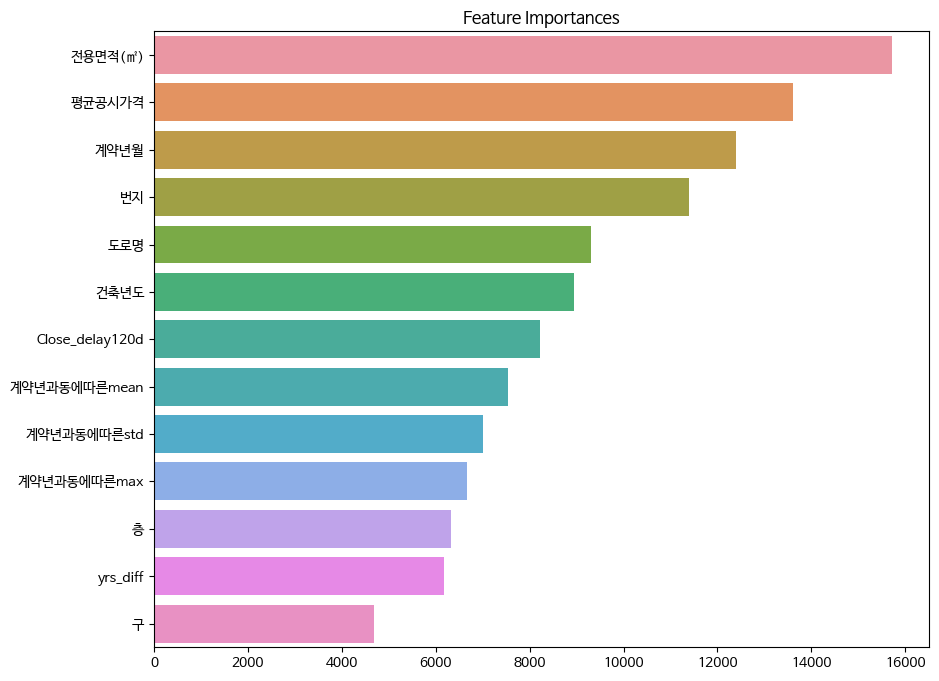

In [94]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(gbm.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [102]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(gbm,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

Weight,Feature
753550505.0972 ± 3007043.5677,평균공시가격
701006627.0561 ± 3139224.9520,전용면적(㎡)
421757276.3713 ± 4222652.0333,계약년월
219680738.8153 ± 967450.1692,계약년과동에따른mean
83004427.5918 ± 2187377.1657,건축년도
34257829.2060 ± 426740.7998,구
25596123.7473 ± 928269.0785,계약년과동에따른std
23046155.1591 ± 393975.7592,번지
20091468.0814 ± 662327.2194,도로명
17527011.4710 ± 562263.5723,층


In [95]:
preds_df.describe().round(2)

,target
count,9272.00
mean,108076.63
std,78058.76
min,7912.00
25%,63286.25
50%,88150.00
75%,127506.75
max,1192027.00


In [ ]:
# # 민규님 모델 최종 describe
# target
# count	9.272000e+03
# mean	1.081633e+05
# std	7.817646e+04
# min	8.641000e+03
# 25%	6.327575e+04
# 50%	8.840000e+04
# 75%	1.276938e+05
# max	1.270070e+06

In [96]:
best_model.best_score_

defaultdict(collections.OrderedDict,
            {'training': OrderedDict([('rmse', 3612.256845708519),
                          ('l2', 13048399.519368056)]),
             'valid_1': OrderedDict([('rmse', 5579.312116017838),
                          ('l2', 31128723.687943444)])})

In [101]:
real_test_pred_best = best_model.predict(X_test)
preds_df = pd.DataFrame(real_test_pred_best.astype(int), columns=["target"])
preds_df.to_csv('gu-dong-encoded_optuna.csv', index=False)

[LightGBM] [Warning] feature_fraction is set=0.6691188003121078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6691188003121078
[LightGBM] [Warning] lambda_l2 is set=1.5944039983833933e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5944039983833933e-08
[LightGBM] [Warning] lambda_l1 is set=1.7965786613884013e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7965786613884013e-05
[LightGBM] [Warning] bagging_fraction is set=0.9858111931327013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9858111931327013


In [104]:
best_model.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': 49,
 'min_child_samples': 233,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 4368,
 'n_jobs': None,
 'num_leaves': 177,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'feature_fraction': 0.6691188003121078,
 'bagging_fraction': 0.9858111931327013,
 'lambda_l1': 1.7965786613884013e-05,
 'lambda_l2': 1.5944039983833933e-08}

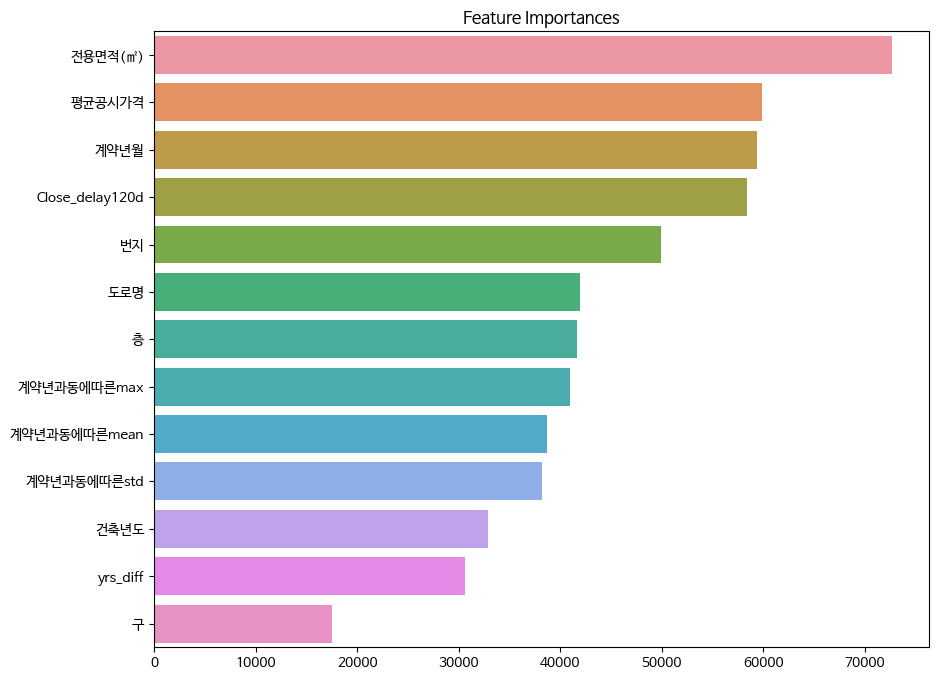

In [100]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [97]:
# Permutation importance 방법을 변수 선택에 이용해보겠습니다.
perm = PermutationImportance(best_model,        # 위에서 학습된 모델을 이용하겠습니다.
                             scoring = "neg_mean_squared_error",        # 평가 지표로는 회귀문제이기에 negative rmse를 사용합니다. (neg_mean_squared_error : 음의 평균 제곱 오차)
                             random_state = 42,
                             n_iter=3).fit(X_val, y_val)
eli5.show_weights(perm, feature_names = X_val.columns.tolist())    # valid data에 대해 적합시킵니다.

[LightGBM] [Warning] feature_fraction is set=0.6691188003121078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6691188003121078
[LightGBM] [Warning] lambda_l2 is set=1.5944039983833933e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5944039983833933e-08
[LightGBM] [Warning] lambda_l1 is set=1.7965786613884013e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7965786613884013e-05
[LightGBM] [Warning] bagging_fraction is set=0.9858111931327013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9858111931327013
[LightGBM] [Warning] feature_fraction is set=0.6691188003121078, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6691188003121078
[LightGBM] [Warning] lambda_l2 is set=1.5944039983833933e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5944039983833933e-08
[LightGBM] [Warning] lambda_l1 is set=1.7965786613884013e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.

Weight,Feature
696510611.0318 ± 4660732.0990,평균공시가격
681706208.6096 ± 3263970.7533,전용면적(㎡)
414846920.3754 ± 3599617.7478,계약년월
269959829.3291 ± 775461.9399,계약년과동에따른mean
85288279.9222 ± 2411955.1548,건축년도
26235961.3594 ± 583744.6788,계약년과동에따른std
24100735.2767 ± 197333.3597,구
22640589.5107 ± 511901.6903,번지
18003708.1845 ± 226667.4120,도로명
17038369.4719 ± 298147.9694,계약년과동에따른max


In [103]:
preds_df.describe().round(2)

,target
count,9272.00
mean,108410.32
std,77147.56
min,8109.00
25%,63425.75
50%,88592.50
75%,128348.50
max,1163416.00
